In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras import layers, models, Sequential
from datetime import timedelta
from scipy import stats as scipy_stats
import io
import base64
import os

plt.rcParams.update(
    {
        "grid.linewidth": 0.5,
        "grid.alpha": 0.5,
        "figure.dpi": 300,
        "savefig.dpi": 300,
        "savefig.bbox": "tight",
        "figure.figsize": (12, 7),
        "font.size": 10,  # base font size
        "axes.titlesize": 12,  # axes title
        "axes.labelsize": 10,  # axes labels
        "xtick.labelsize": 10,  # x tick labels
        "ytick.labelsize": 10,  # y tick labels
        "legend.fontsize": 10,  # legend
        "figure.titlesize": 12,  # figure title
    }
)

raw_df = pd.read_excel("./data/FullDayWithAlarms.xlsx", header=1)
raw_df
# Rename columns for clarity
raw_df.rename(
    columns={
        "COD \nGIOCO": "Code_ID",
        "DATA ORA": "Timestamp",
        "INTERVALLO\nACQUISIZIONE": "Interval_s",
        "NUMERO\nTRANSAZIONI": "Num_Transactions",
        "TEMPO MIN": "Time_Min",
        "TEMPO MAX": "Time_Max",
        "TEMPO MEDIO": "Mean_Time",
        "NUMERO RETRY": "Num_Retries",
        "NUMERO \nTRANSAZIONI ERRATE": "Num_Wrong_Transactions",
    },
    inplace=True,
)

# # Parse and sort timestamps
raw_df["Timestamp"] = pd.to_datetime(
    raw_df["Timestamp"], dayfirst=True, errors="coerce"
)
raw_df.sort_values("Timestamp", inplace=True)
raw_df.reset_index(drop=True, inplace=True)


2025-05-15 18:26:41.165736: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-15 18:26:41.172838: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-15 18:26:41.186005: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747326401.210114    8481 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747326401.216299    8481 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747326401.238214    8481 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [2]:
raw_df

,Code_ID,Timestamp,Interval_s,Num_Transactions,Time_Min,Time_Max,Mean_Time,Num_Retries,Num_Wrong_Transactions
0,8,2024-05-31 07:01:11,60,366,6,1019,25.907562,0,90
1,8,2024-05-31 07:02:11,60,948,7,90,18.181719,0,90
2,8,2024-05-31 07:03:11,60,1273,7,408,18.813356,0,90
3,8,2024-05-31 07:04:11,60,1538,6,70,16.607435,0,90
4,8,2024-05-31 07:05:11,60,703,5,85,16.645409,0,90
...,...,...,...,...,...,...,...,...,...
1013,8,2024-05-31 23:55:23,60,1061,3,83,10.171293,0,167
1014,8,2024-05-31 23:56:23,60,974,3,53,10.172589,0,185
1015,8,2024-05-31 23:57:23,60,995,4,55,9.933611,0,141
1016,8,2024-05-31 23:58:23,60,936,3,39,10.171029,0,196


In [3]:
# Quick summary and missing values
print("Dataset shape:", raw_df.shape)
print("\nMissing values per column:")
raw_df.isnull().sum()

Dataset shape: (1018, 9)

Missing values per column:


Code_ID                   0
Timestamp                 0
Interval_s                0
Num_Transactions          0
Time_Min                  0
Time_Max                  0
Mean_Time                 0
Num_Retries               0
Num_Wrong_Transactions    0
dtype: int64

In [4]:
raw_df.describe()

,Code_ID,Timestamp,Interval_s,Num_Transactions,Time_Min,Time_Max,Mean_Time,Num_Retries,Num_Wrong_Transactions
count,1018.0,1018,1018.0,1018.000000,1018.000000,1018.000000,1018.000000,1018.000000,1018.000000
mean,8.0,2024-05-31 15:30:13.430255616,60.0,2245.859528,2.737721,1346.666994,49.715493,89.292731,155.943026
min,8.0,2024-05-31 07:01:11,60.0,204.000000,0.000000,28.000000,9.462604,0.000000,81.000000
25%,8.0,2024-05-31 11:15:37,60.0,1424.750000,3.000000,82.000000,11.039727,0.000000,122.250000
50%,8.0,2024-05-31 15:30:09,60.0,2323.000000,3.000000,124.000000,12.349440,0.000000,149.000000
75%,8.0,2024-05-31 19:44:54,60.0,3007.000000,3.000000,232.500000,13.582763,0.000000,186.000000
max,8.0,2024-05-31 23:59:23,60.0,5057.000000,7.000000,92682.000000,2019.271700,6496.000000,448.000000
std,0.0,NaN,0.0,1136.991871,0.934939,7207.947520,182.782991,599.256239,47.440950


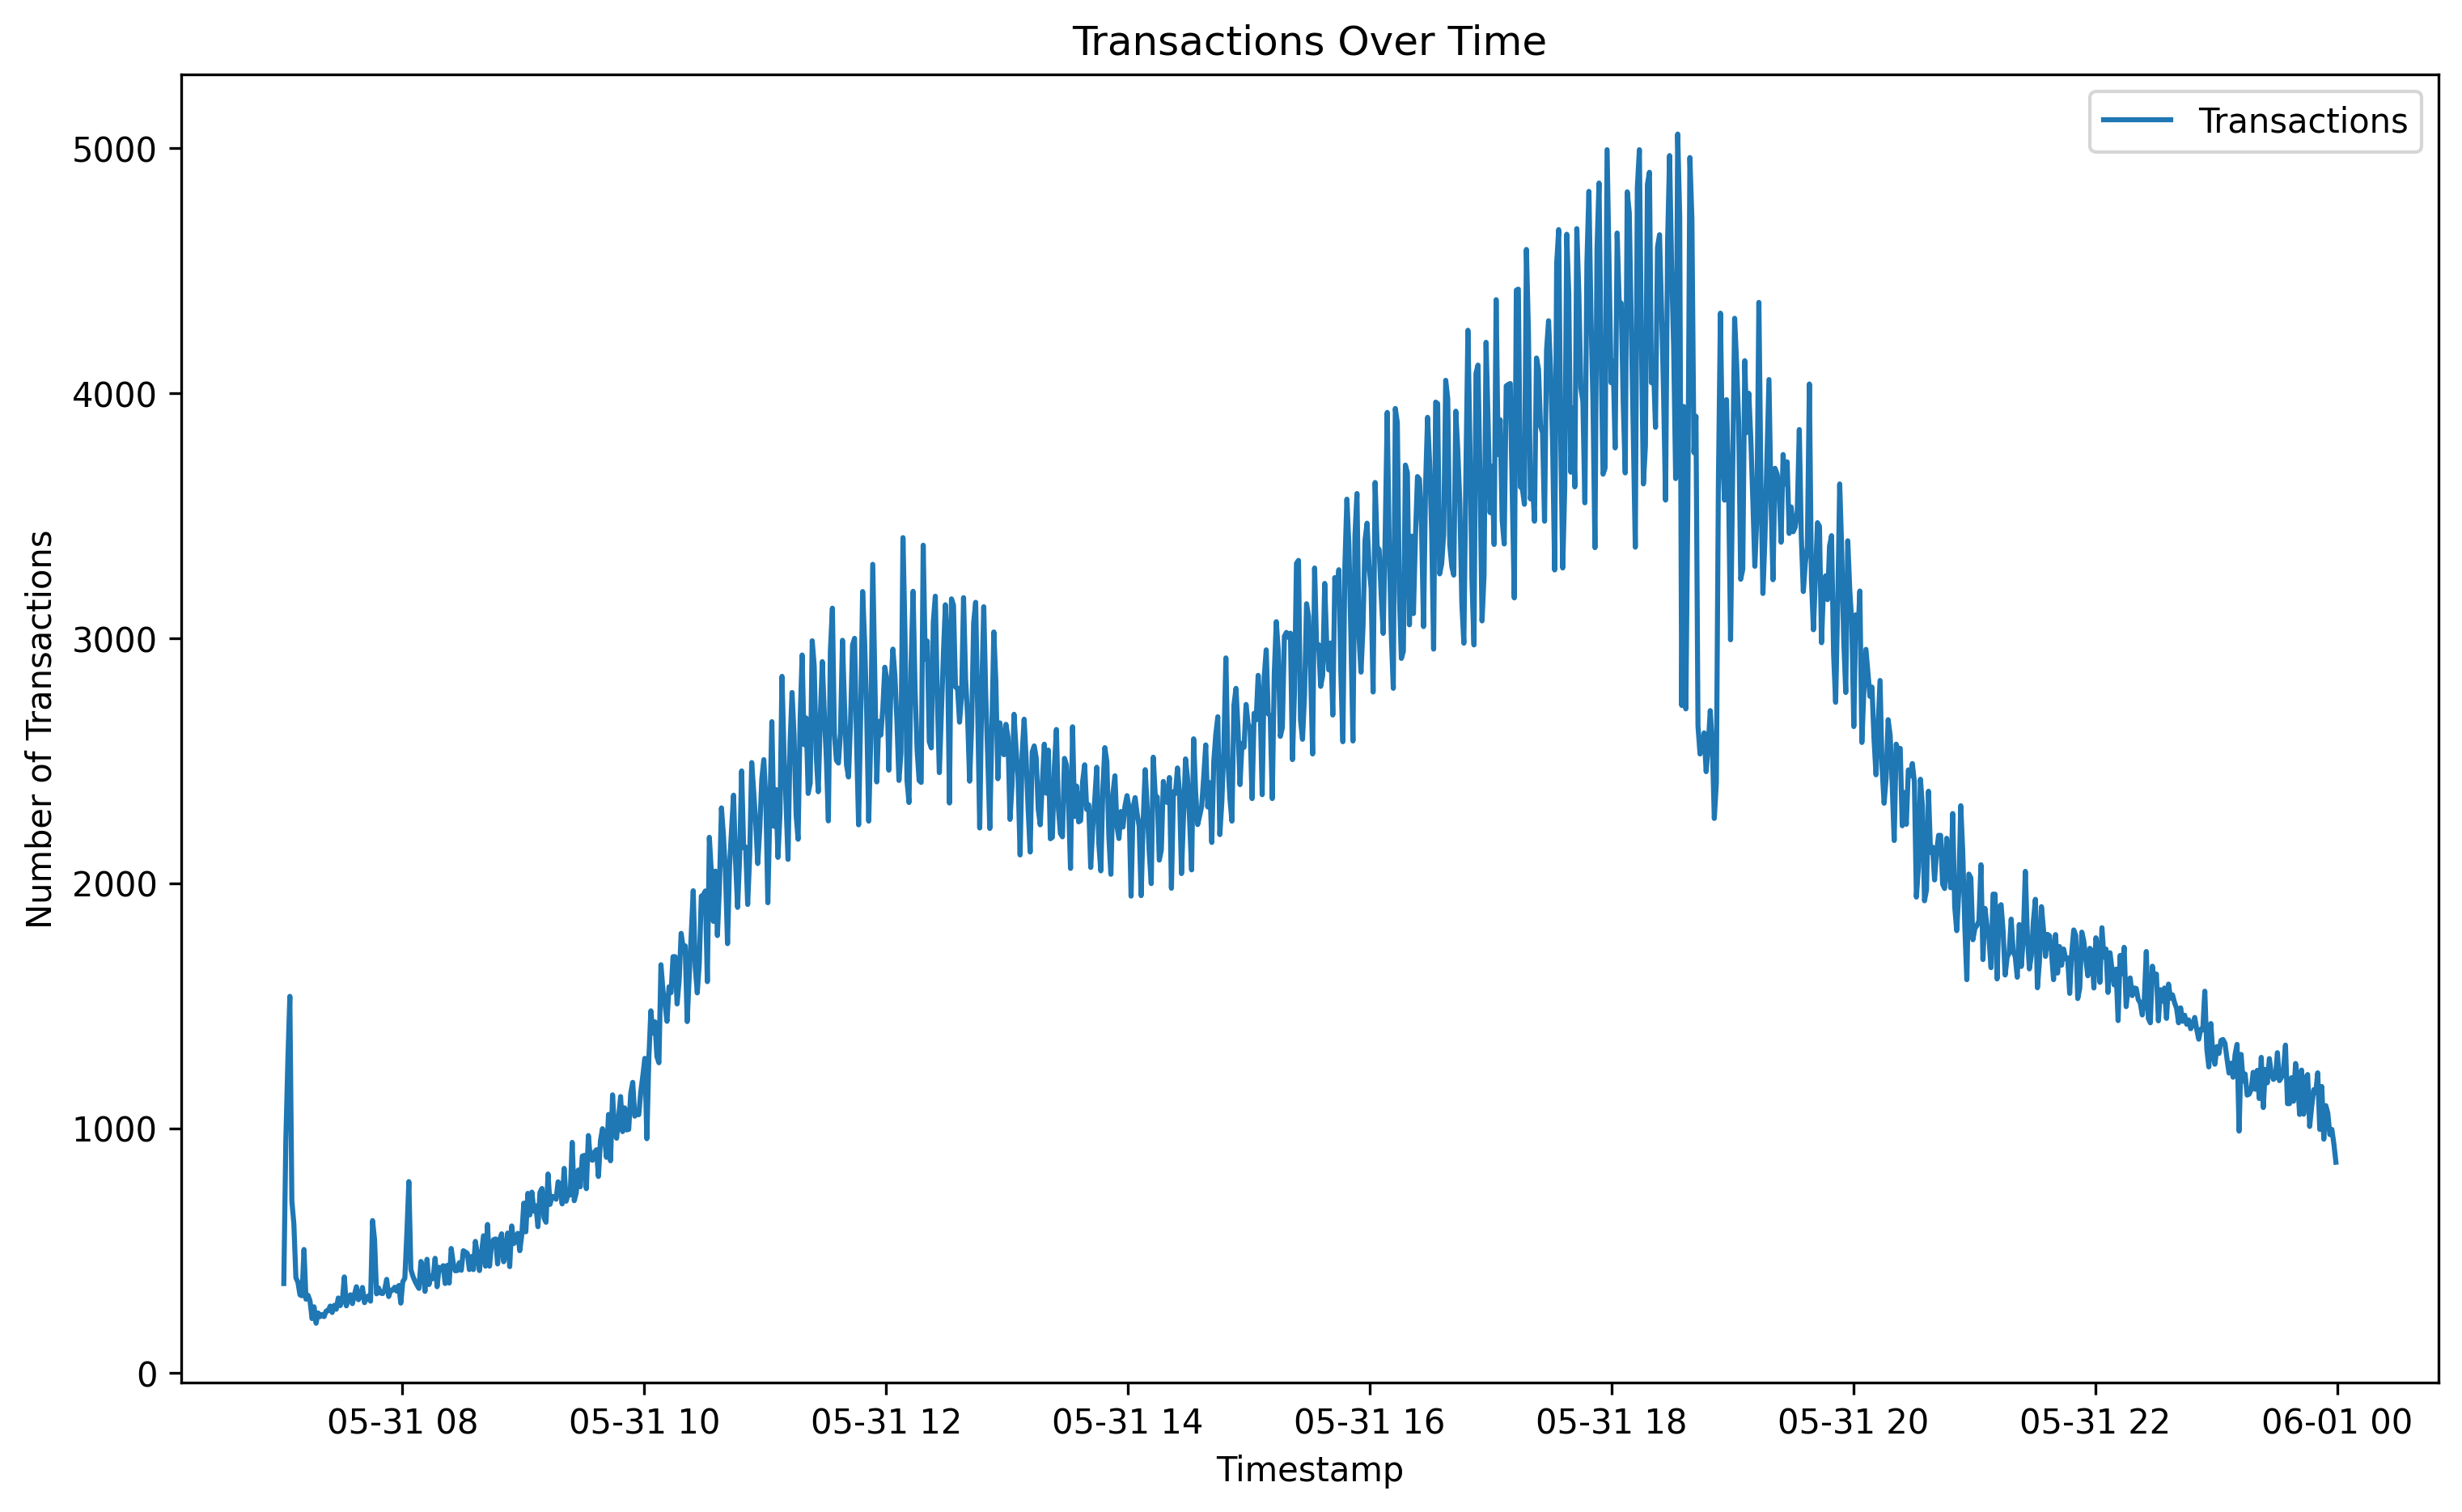

In [5]:
# 6. Plot key time series
plt.plot(raw_df['Timestamp'], raw_df["Num_Transactions"], label="Transactions")
plt.xlabel("Timestamp")
plt.ylabel("Number of Transactions")
plt.title("Transactions Over Time")
plt.legend()
plt.savefig("./images/00-transactions_over_time_original_data.png")

In [6]:
records_per_day = raw_df.shape[0] 
records_per_day

1018

In [7]:
# Configuration for variations - set these to True/False to enable/disable
VARIATION_CONFIG = {
    "increased_noise": True,  # #1: Increase noise levels
    "add_outliers": False,  # #3: Add occasional outliers
    "vary_distributions": True,  # #4: Vary sampling distributions
    "add_time_trends": False,  # #5: Add time-based trends
    "vary_sequences": True,  # #6: Use different sequence patterns
    "modify_correlations": True,  # #7: Modify correlation structure
}
increased_noise_VARIATION = 0.10  # Increase noise levels by this factor
increased_noise_Factor = 1.08  # Increase noise levels by this factor

outlier_col = np.random.choice(["Num_Transactions", "Time_Max"])
outlier_factor = np.random.choice(
    [1.07, 1.06, 1.05, 1.02, 1, 0.97, 0.96, 0.95, 0.93]
)  # Either much higher or lower


# Function to create visualizations of patterns
def create_pattern_visualizations(df):
    # Convert timestamp to datetime
    df["Timestamp"] = pd.to_datetime(df["Timestamp"])

    # Create a figure with multiple subplots
    fig, axes = plt.subplots(7, 2, figsize=(20, 24))

    # List of columns to analyze
    columns = [
        "Interval_s",
        "Num_Transactions",
        "Time_Min",
        "Time_Max",
        "Mean_Time",
        "Num_Retries",
        "Num_Wrong_Transactions",
    ]

    # Create time series plots and histograms
    for i, col in enumerate(columns):
        # Time series plot
        axes[i, 0].plot(df["Timestamp"], df[col])
        axes[i, 0].set_title(f"{col} Time Series")
        axes[i, 0].set_xlabel("Time")
        axes[i, 0].set_ylabel(col)
        axes[i, 0].tick_params(axis="x", rotation=45)

        # Histogram
        axes[i, 1].hist(df[col], bins=30)
        axes[i, 1].set_title(f"{col} Distribution")
        axes[i, 1].set_xlabel(col)
        axes[i, 1].set_ylabel("Frequency")

    plt.tight_layout()

    # Save the figure to a bytes buffer
    buf = io.BytesIO()
    plt.savefig(buf, format="png")
    buf.seek(0)

    # Convert the image to base64 string
    img_str = base64.b64encode(buf.read()).decode("utf-8")
    plt.close(fig)

    return img_str


# Comprehensive analysis of your existing data
def analyze_data(df):
    # Make a copy to avoid modifying the original dataframe
    df_copy = df.copy()

    # Sort by timestamp
    df_copy = df_copy.sort_values("Timestamp")

    # Basic statistics
    stats = {}
    for col in [
        "Interval_s",
        "Num_Transactions",
        "Time_Min",
        "Time_Max",
        "Mean_Time",
        "Num_Retries",
        "Num_Wrong_Transactions",
    ]:
        stats[col] = {
            "min": float(df_copy[col].min()),
            "max": float(df_copy[col].max()),
            "mean": float(df_copy[col].mean()),
            "median": float(df_copy[col].median()),
            "std": float(df_copy[col].std()),
            "q1": float(df_copy[col].quantile(0.25)),
            "q3": float(df_copy[col].quantile(0.75)),
            "skew": float(scipy_stats.skew(df_copy[col])),
            "kurtosis": float(scipy_stats.kurtosis(df_copy[col])),
        }

    return {
        "basic_stats": stats,
    }


# Perform the analysis
analysis = analyze_data(raw_df)


# Function to generate synthetic data using statistical models
def generate_data_for_day(num_records=1018, trend_factor=1.0):
    # Get basic stats for reference
    stats = analysis["basic_stats"]

    # Create a copy of the original data for sampling
    df_copy = raw_df.copy()
    df_copy["Timestamp"] = pd.to_datetime(df_copy["Timestamp"])
    df_copy = df_copy.sort_values("Timestamp")

    # Extract sequences from original data to maintain patterns
    sequence_length = min(24, len(df_copy) // 10)
    sequences = []
    for i in range(
        0, len(df_copy) - sequence_length, sequence_length // 2
    ):  # Overlapping sequences
        seq = df_copy.iloc[i : i + sequence_length].copy()
        sequences.append(seq)

    # Generate data by sampling and modifying sequences
    remaining = num_records
    result_data = []

    while remaining > 0:
        # Randomly select a sequence
        seq = sequences[np.random.randint(0, len(sequences))].copy()
        # Adjust length if needed
        if len(seq) > remaining:
            seq = seq.iloc[:remaining]

        # VARIATION #6: Vary sequence patterns
        if (
            VARIATION_CONFIG["vary_sequences"] and np.random.random() < 0.2
        ):  # 20% of the time
            if np.random.random() < 0.5:
                # Reverse the sequence
                seq = seq.iloc[::-1].reset_index(drop=True)
            else:
                # Shuffle the sequence (but maintain internal correlations)
                idx = np.random.permutation(len(seq))
                seq = seq.iloc[idx].reset_index(drop=True)

        # Modify the sequence to avoid exact duplication
        for col in [
            "Interval_s",
            "Num_Transactions",
            "Time_Min",
            "Time_Max",
            "Mean_Time",
            "Num_Retries",
            "Num_Wrong_Transactions",
        ]:
            # VARIATION #1: Increased noise levels
            noise_level = stats[col]["std"] * (
                increased_noise_VARIATION
                if VARIATION_CONFIG["increased_noise"]
                else 0.1
            )

            if col in ["Num_Transactions", "Num_Retries", "Num_Wrong_Transactions"]:
                # For integer columns
                noise = np.random.randint(-1, 2, size=len(seq))  # -1, 0, or 1
                seq[col] = np.clip(
                    seq[col] + noise, stats[col]["min"], stats[col]["max"]
                ).astype(int)
            else:
                # For float columns
                noise = np.random.normal(0, noise_level, size=len(seq))
                seq[col] = np.clip(
                    seq[col] + noise, stats[col]["min"], stats[col]["max"]
                ).round(2)

            # VARIATION #5: Add time-based trends
            if VARIATION_CONFIG["add_time_trends"]:
                # Apply trend factor
                seq[col] = seq[col] * trend_factor

        # VARIATION #3: Add occasional outliers
        if VARIATION_CONFIG["add_outliers"]:
            for i in range(len(seq)):
                if np.random.random() < 0.01:  # 1% chance of outlier
                    seq.loc[seq.index[i], outlier_col] = (
                        seq.loc[seq.index[i], outlier_col] * outlier_factor
                    )

                    # Ensure constraints are still met
                    if outlier_col == "Time_Max":
                        seq.loc[seq.index[i], "Time_Max"] = max(
                            seq.loc[seq.index[i], "Time_Max"],
                            seq.loc[seq.index[i], "Time_Min"] * 1.05,
                        )
                        seq.loc[seq.index[i], "Mean_Time"] = (
                            seq.loc[seq.index[i], "Time_Min"]
                            + seq.loc[seq.index[i], "Time_Max"]
                        ) / 2

        # VARIATION #7: Modify correlation structure
        if VARIATION_CONFIG["modify_correlations"]:
            for i in range(len(seq)):
                if np.random.random() < 0.3:  # 30% of the time
                    # Find two correlated columns
                    corr_cols = ["Time_Min", "Time_Max"]
                    # Get current values
                    val1, val2 = (
                        seq.loc[seq.index[i], corr_cols[0]],
                        seq.loc[seq.index[i], corr_cols[1]],
                    )
                    # Add independent noise to slightly decorrelate
                    seq.loc[seq.index[i], corr_cols[0]] = val1 * (
                        1 + np.random.normal(0, 0.05)
                    )
                    seq.loc[seq.index[i], corr_cols[1]] = val2 * (
                        1 + np.random.normal(0, 0.05)
                    )
                    # Ensure constraints
                    if (
                        corr_cols == ["Time_Min", "Time_Max"]
                        and seq.loc[seq.index[i], "Time_Max"]
                        <= seq.loc[seq.index[i], "Time_Min"]
                    ):
                        seq.loc[seq.index[i], "Time_Max"] = (
                            seq.loc[seq.index[i], "Time_Min"] * 1.1
                        )

        # Ensure constraints
        seq["Time_Max"] = np.maximum(seq["Time_Min"] * 1.05, seq["Time_Max"])
        seq["Mean_Time"] = (seq["Time_Min"] + seq["Time_Max"]) / 2

        # Add to result
        result_data.append(seq)
        remaining -= len(seq)

    # Combine all generated data
    if result_data:
        combined_df = pd.concat(result_data, ignore_index=True)

        # Sort by timestamp
        combined_df["Timestamp"] = pd.to_datetime(combined_df["Timestamp"])
        combined_df = combined_df.sort_values("Timestamp").reset_index(drop=True)

        # Ensure we have exactly num_records
        if len(combined_df) > num_records:
            combined_df = combined_df.iloc[:num_records]

        return combined_df
    else:
        return None


# Generate data for multiple days
def generate_multiple_days(num_days, records_per_day=1018):
    all_data = []

    # VARIATION #5: Initialize trend factor
    trend_factor = 1.0
    trend_direction = np.random.choice([-1, 1])  # Random direction

    for i in range(num_days):
        # VARIATION #5: Update trend factor if enabled
        if VARIATION_CONFIG["add_time_trends"]:
            trend_factor += trend_direction * 0.02  # 2% change per day
            # Reverse direction if trend gets too extreme
            if trend_factor > 1.2 or trend_factor < 0.8:
                trend_direction *= -1
            print(f"Using trend factor: {trend_factor:.2f}")

        day_data = generate_data_for_day(records_per_day, trend_factor)
        if day_data is not None:
            all_data.append(day_data)

    return pd.concat(all_data, ignore_index=True)


# Example usage
num_days_to_generate = 9  # Variable number of days


file_path = "./data/generated_transaction_data.csv"
gen_data = None
if os.path.exists(file_path):
    gen_data = pd.read_csv(file_path, parse_dates=True)
    gen_data["Timestamp"] = pd.to_datetime(
        gen_data["Timestamp"], dayfirst=False, errors="coerce"
    )
else:
    gen_data = generate_multiple_days(num_days_to_generate, records_per_day)
    time_stamps = []
    for i in range(num_days_to_generate):
        time_stamps.append(raw_df["Timestamp"] + timedelta(days=i + 1))
    time_stamps = np.reshape(time_stamps, (num_days_to_generate * records_per_day))

    gen_data["Timestamp"] = time_stamps
    gen_data["Code_ID"] = 8
    gen_data["Interval_s"] = 60
    gen_data["Num_Transactions"] = gen_data["Num_Transactions"].astype(int)
    gen_data["Num_Retries"] = gen_data["Num_Retries"].astype(int)
    gen_data["Num_Wrong_Transactions"] = gen_data["Num_Wrong_Transactions"].astype(int)
    gen_data["Time_Min"] = gen_data["Time_Min"].astype(int)
    gen_data["Time_Max"] = gen_data["Time_Max"].astype(int)
    gen_data["Timestamp"] = pd.to_datetime(
        gen_data["Timestamp"], dayfirst=True, errors="coerce"
    )

    gen_data.to_csv(file_path, index=False)
    print(
        f"Successfully generated {len(gen_data)} records for {num_days_to_generate} days"
    )
    print(gen_data.head())

    # Validate the generated data
    print("\nOriginal data statistics:")
    for col in [
        "Interval_s",
        "Num_Transactions",
        "Time_Min",
        "Time_Max",
        "Mean_Time",
        "Num_Retries",
        "Num_Wrong_Transactions",
    ]:
        print(
            f"{col}: mean={raw_df[col].mean():.2f}, std={raw_df[col].std():.2f}, min={raw_df[col].min():.2f}, max={raw_df[col].max():.2f}"
        )

    print("\nGenerated data statistics:")
    for col in [
        "Interval_s",
        "Num_Transactions",
        "Time_Min",
        "Time_Max",
        "Mean_Time",
        "Num_Retries",
        "Num_Wrong_Transactions",
    ]:
        print(
            f"{col}: mean={gen_data[col].mean():.2f}, std={gen_data[col].std():.2f}, min={gen_data[col].min():.2f}, max={gen_data[col].max():.2f}"
        )


/tmp/ipykernel_8481/3199141783.py:94: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  "skew": float(scipy_stats.skew(df_copy[col])),
/tmp/ipykernel_8481/3199141783.py:95: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  "kurtosis": float(scipy_stats.kurtosis(df_copy[col])),


In [8]:
gen_data

,Code_ID,Timestamp,Interval_s,Num_Transactions,Time_Min,Time_Max,Mean_Time,Num_Retries,Num_Wrong_Transactions
0,8,2024-06-01 07:01:11,60,248,3,28,15.970000,0,90
1,8,2024-06-01 07:02:11,60,277,4,282,143.390000,0,90
2,8,2024-06-01 07:03:11,60,260,4,28,16.065000,1,89
3,8,2024-06-01 07:04:11,60,307,3,131,67.955000,0,90
4,8,2024-06-01 07:05:11,60,275,3,28,16.354894,0,91
...,...,...,...,...,...,...,...,...,...
9157,8,2024-06-09 23:55:23,60,1218,3,28,15.550000,1,184
9158,8,2024-06-09 23:56:23,60,1007,2,1334,668.540000,0,123
9159,8,2024-06-09 23:57:23,60,1088,3,1182,592.680000,1,190
9160,8,2024-06-09 23:58:23,60,1158,3,567,285.525467,1,162


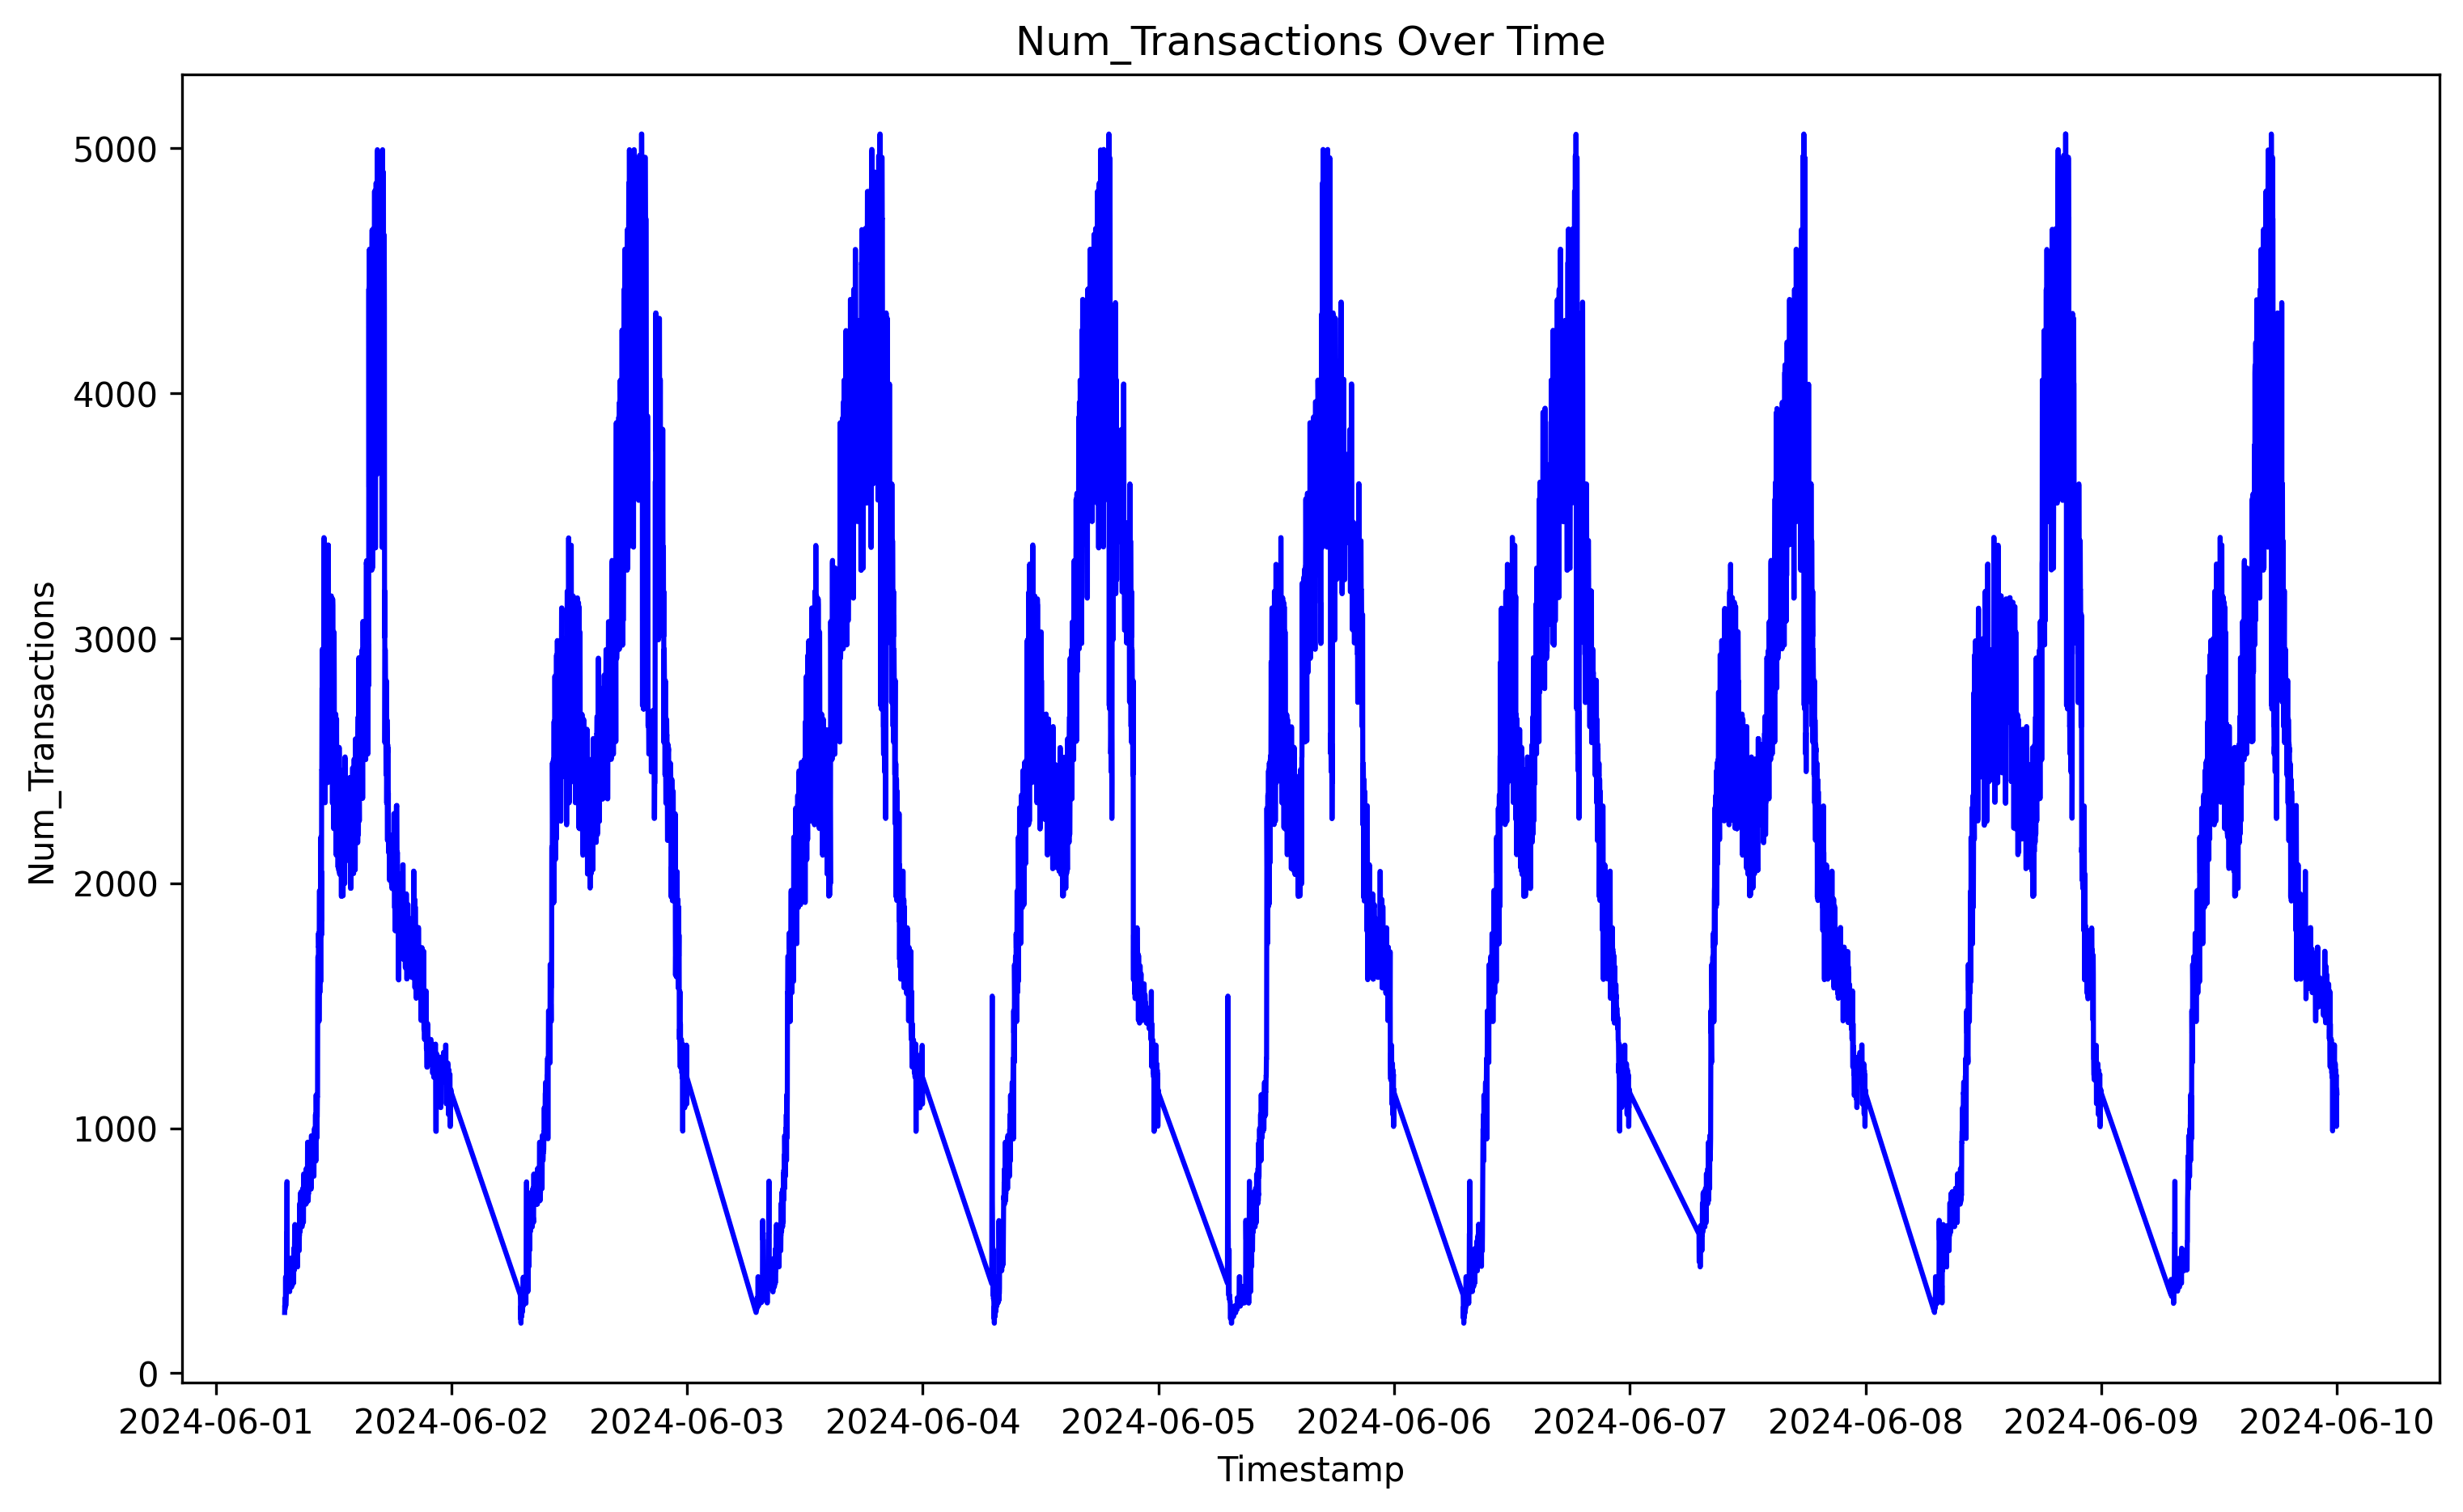

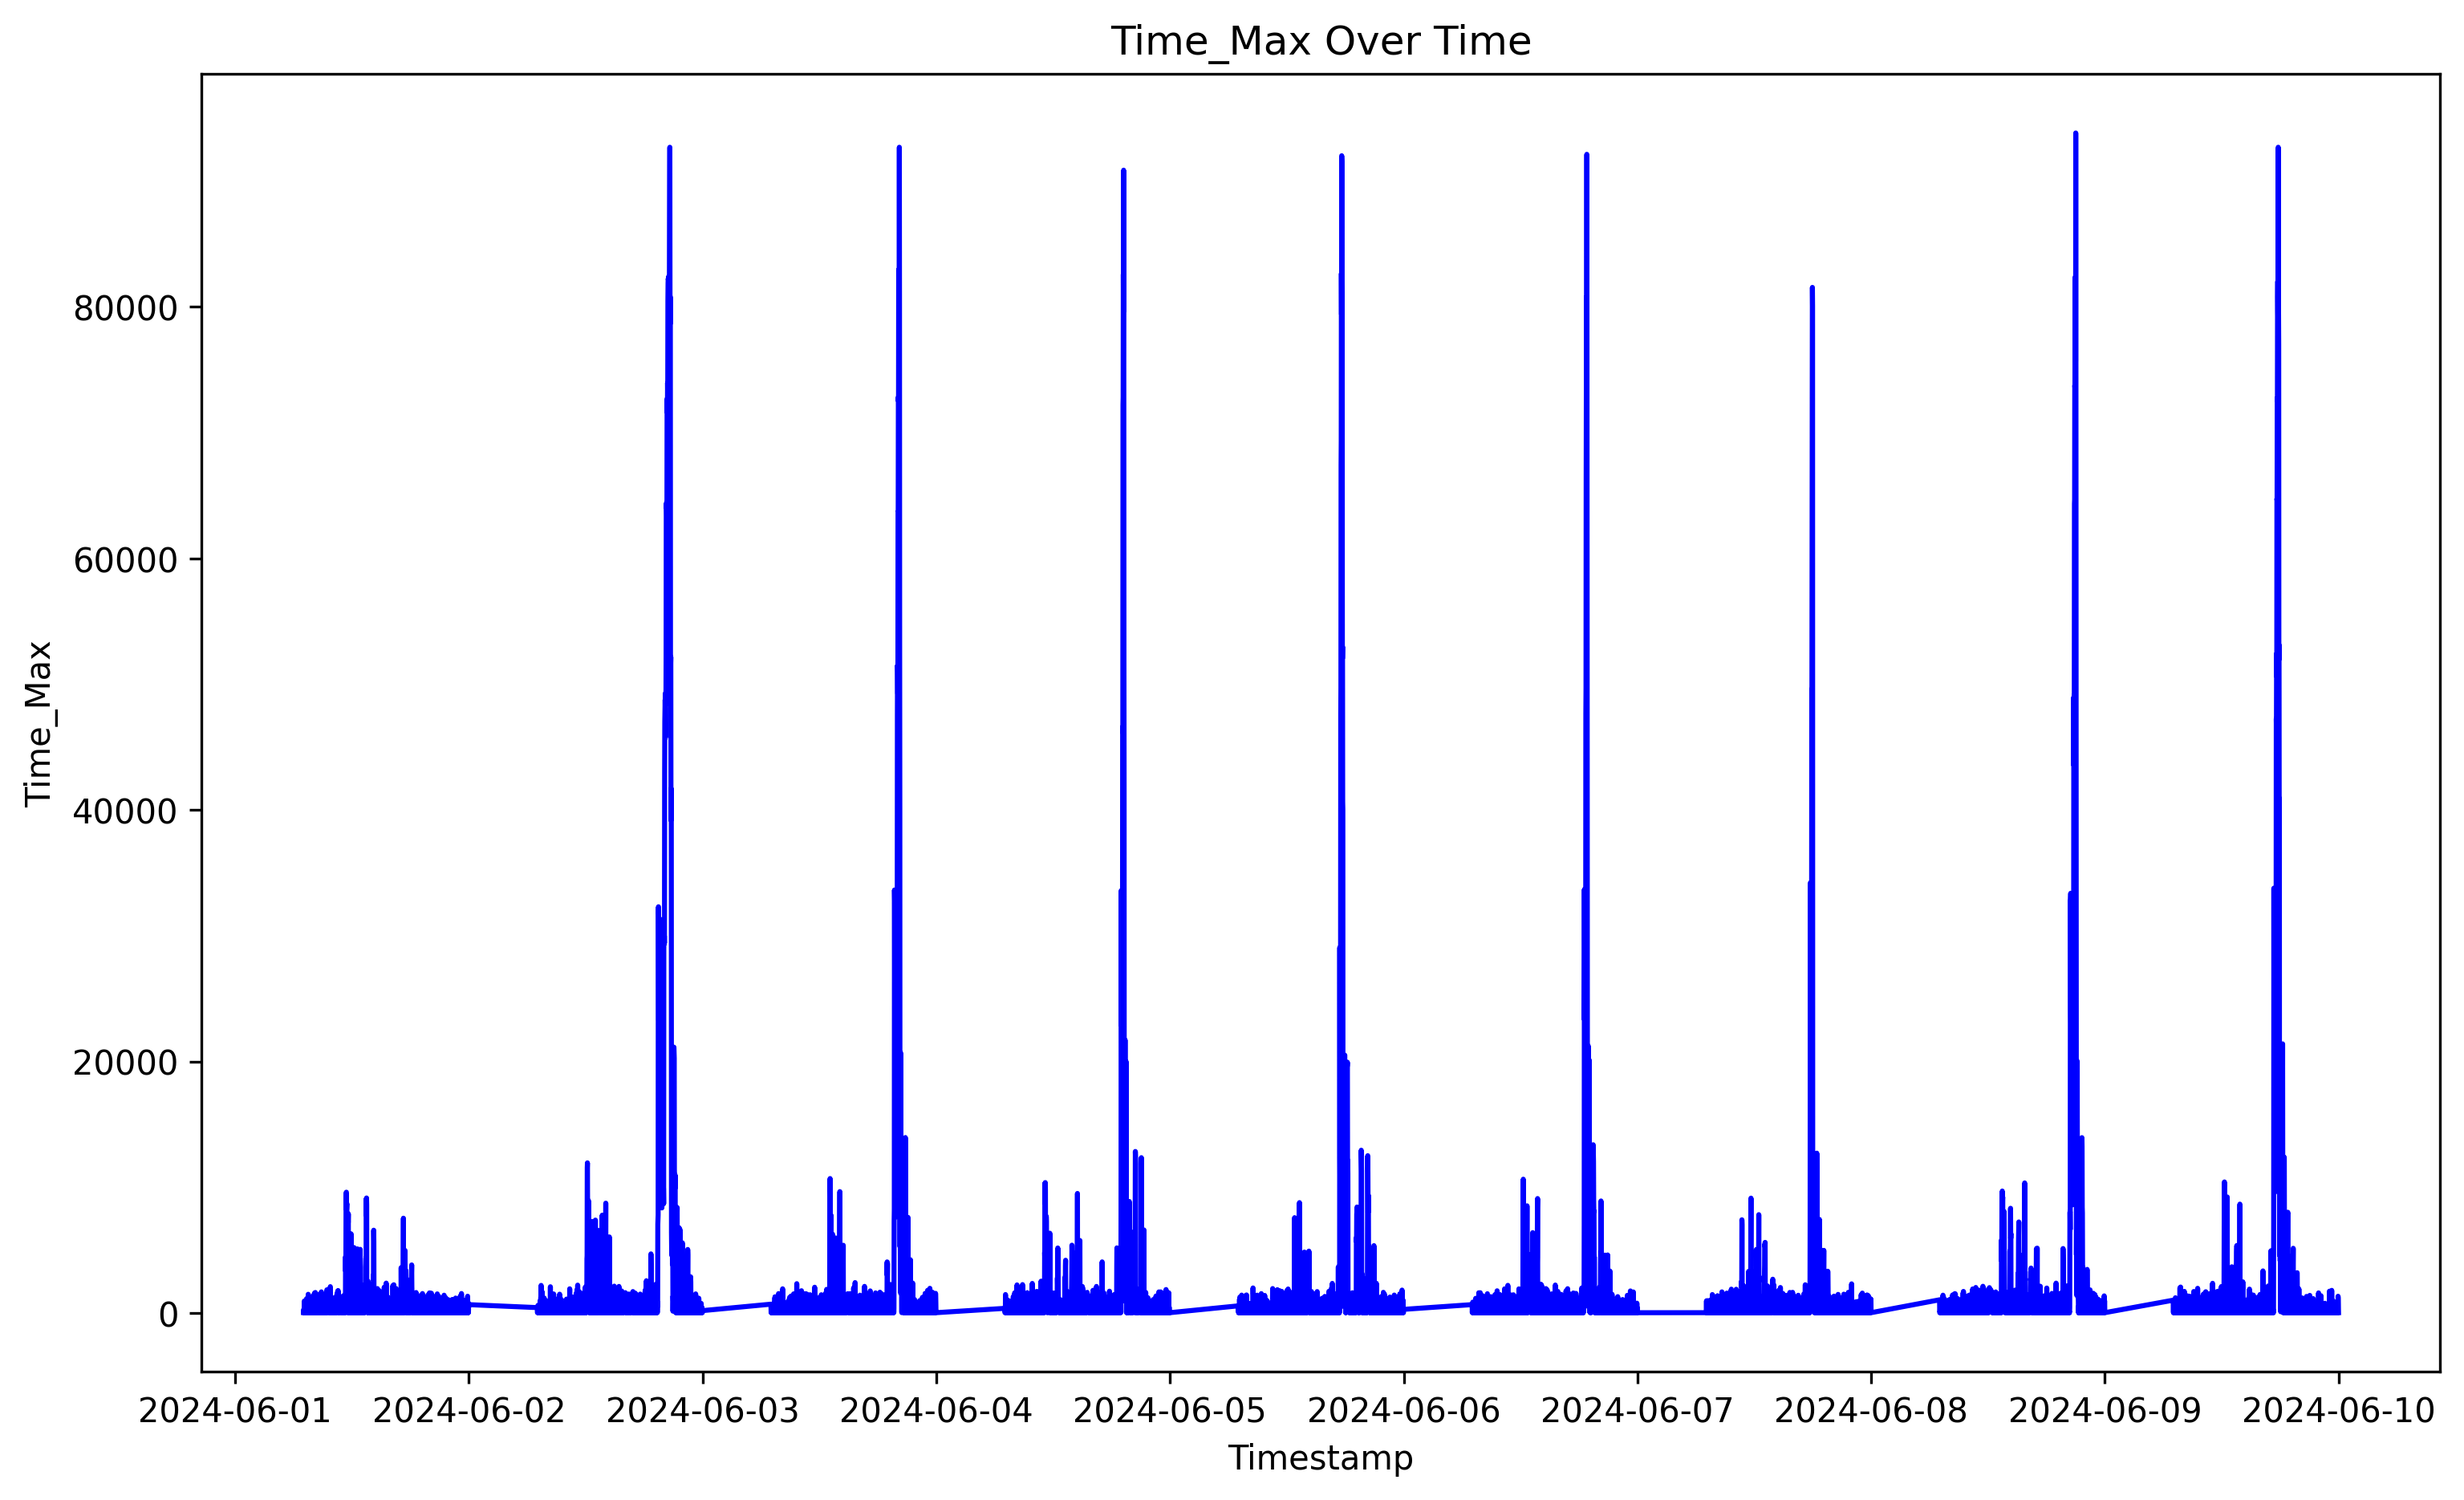

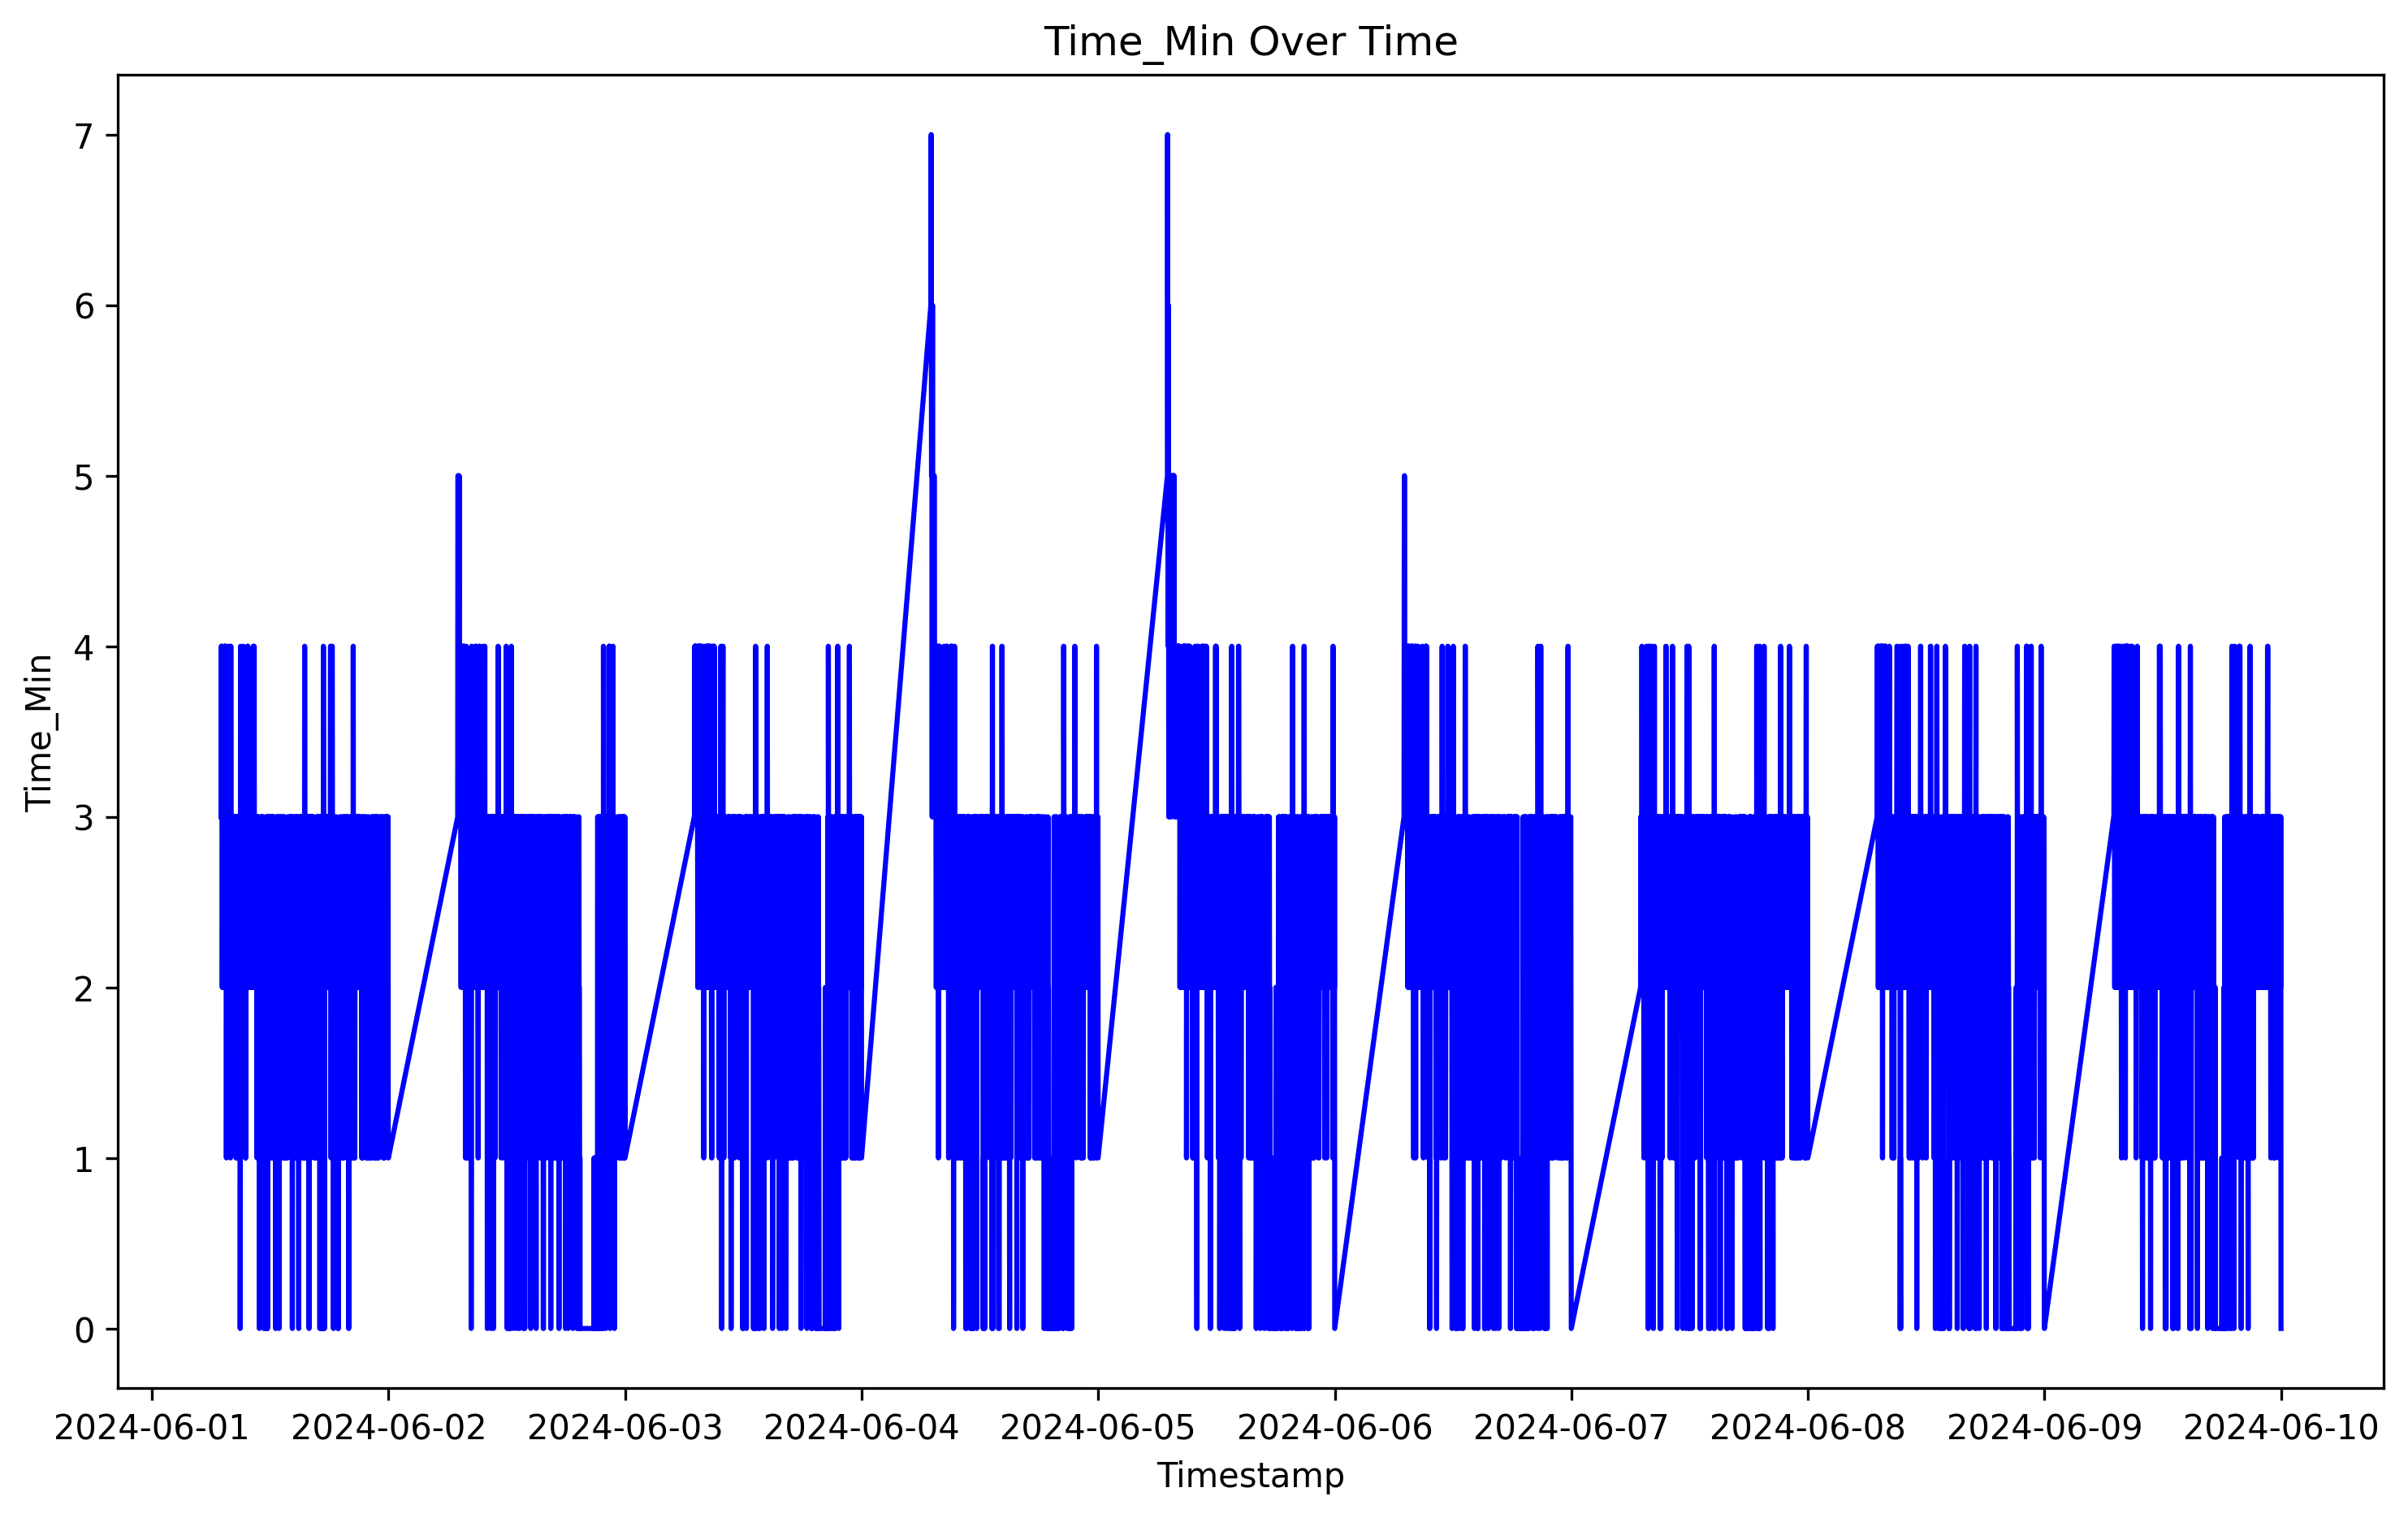

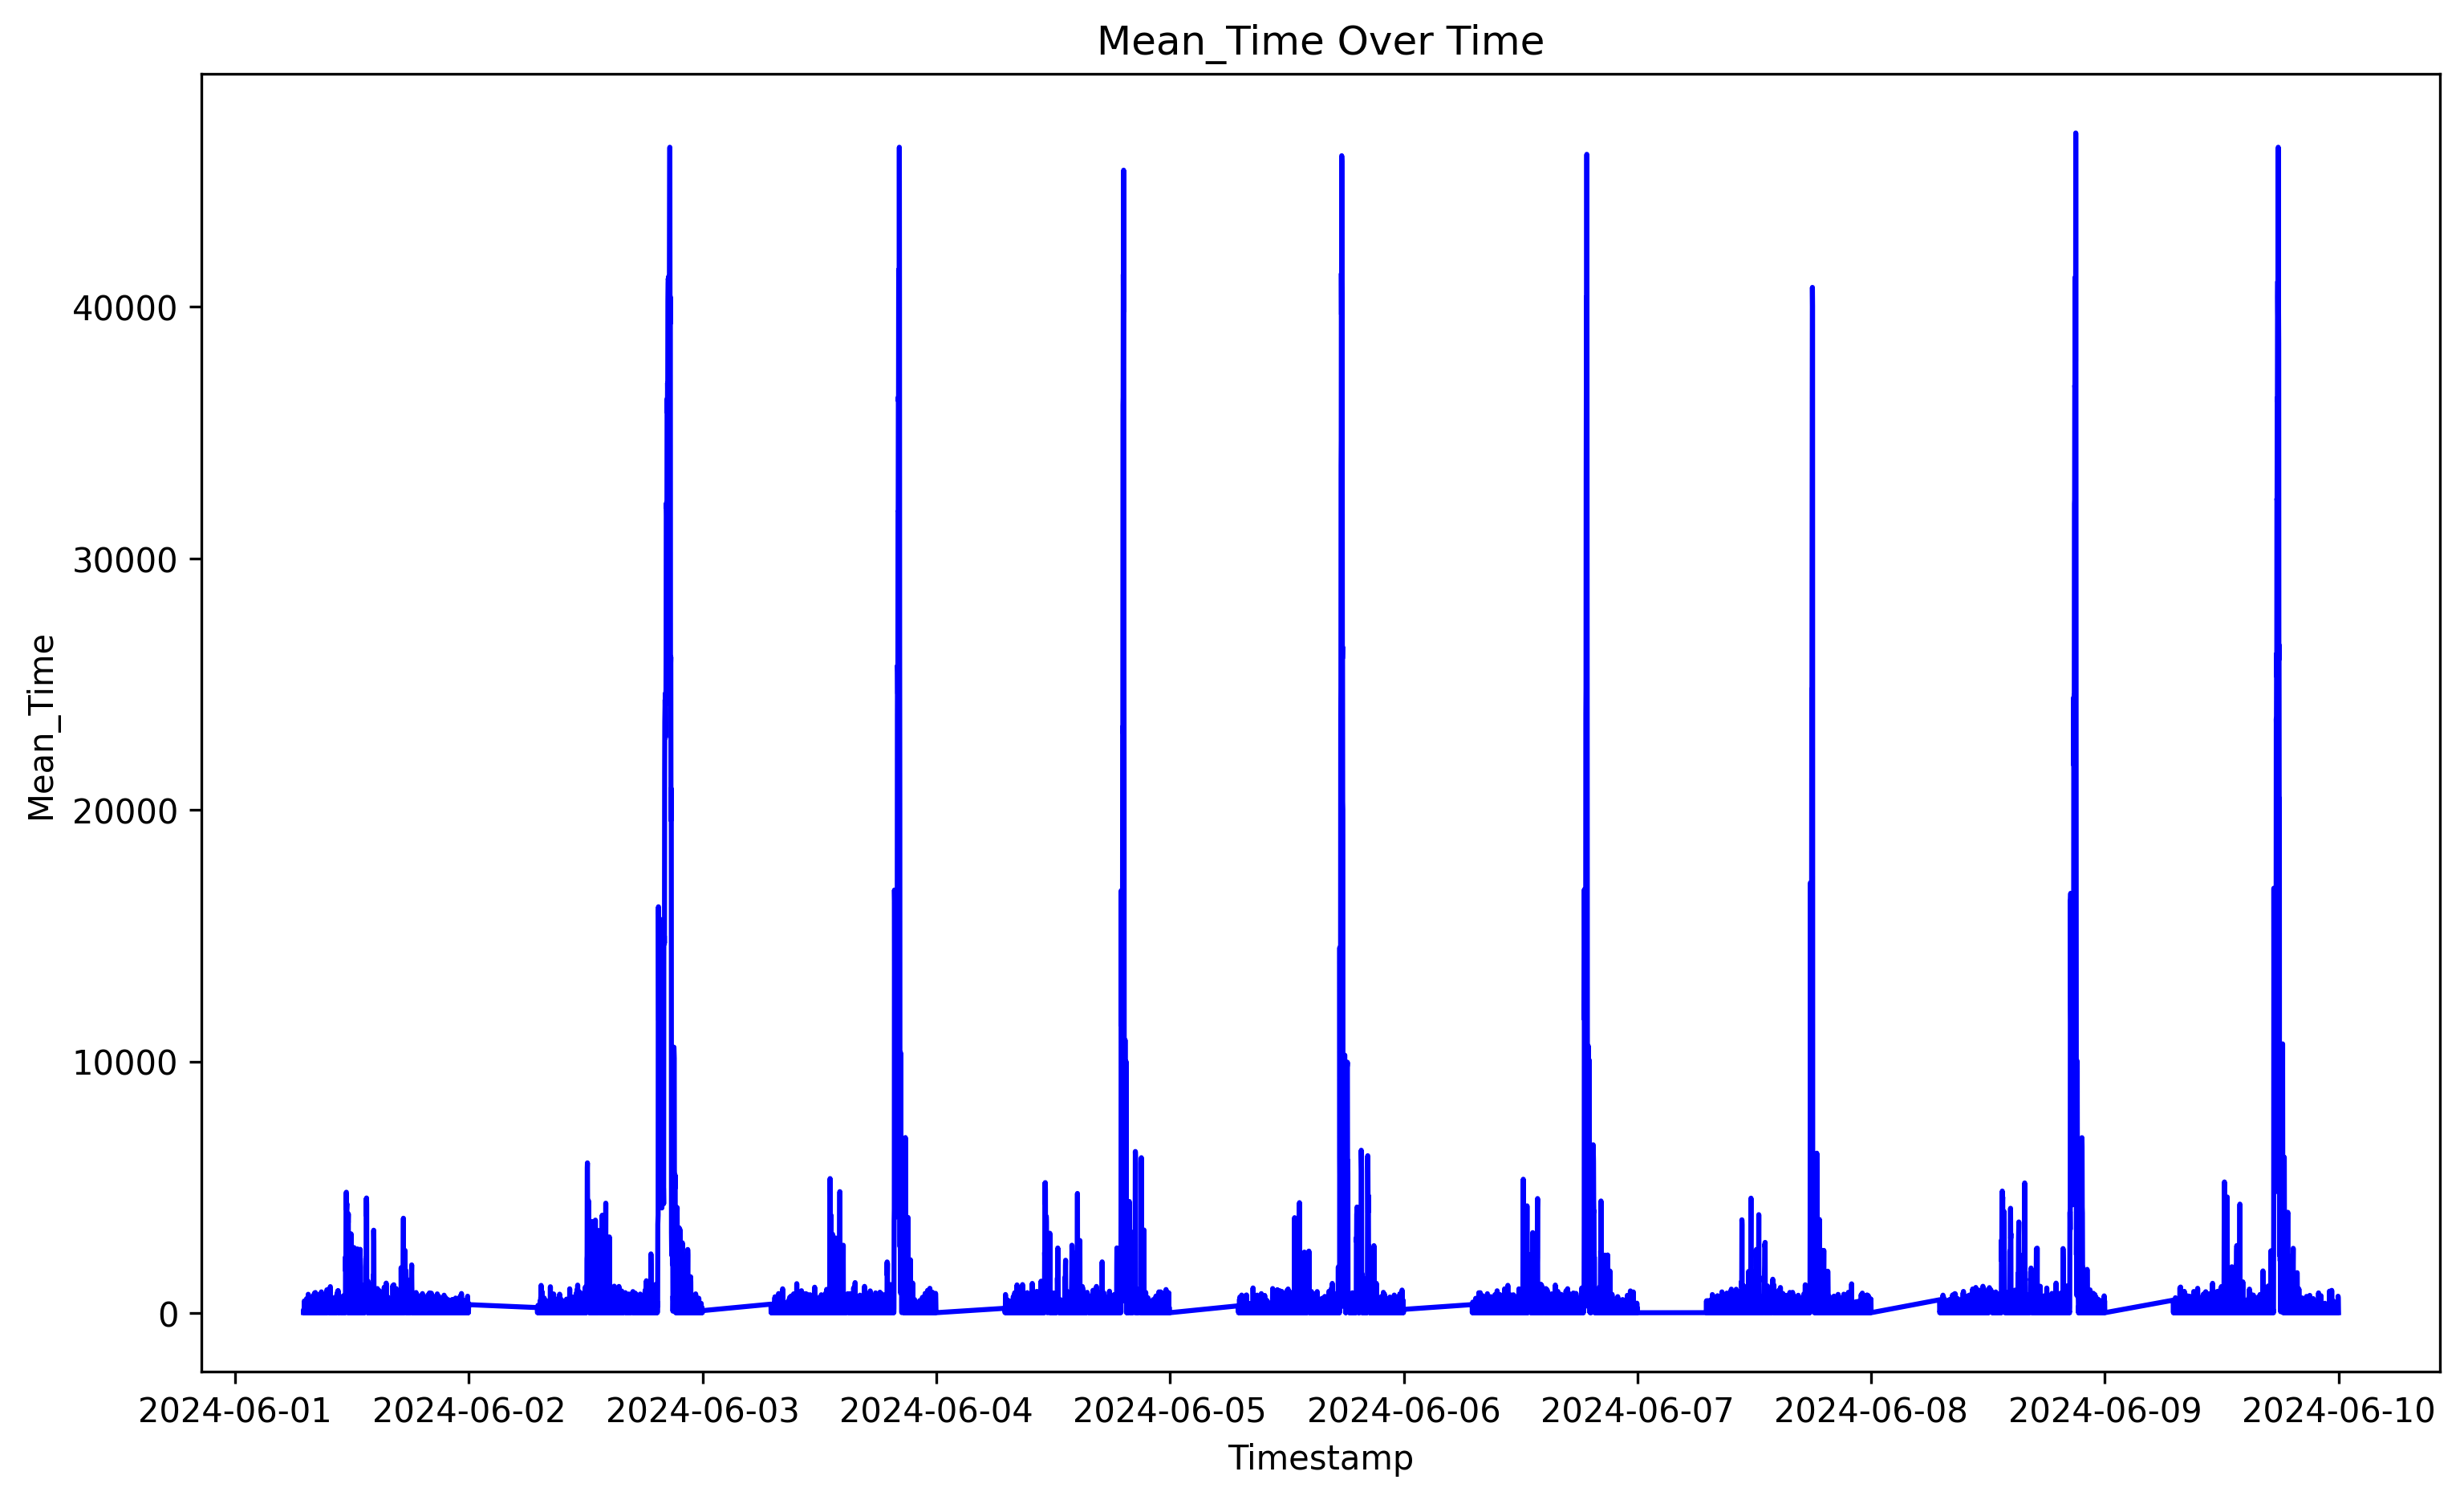

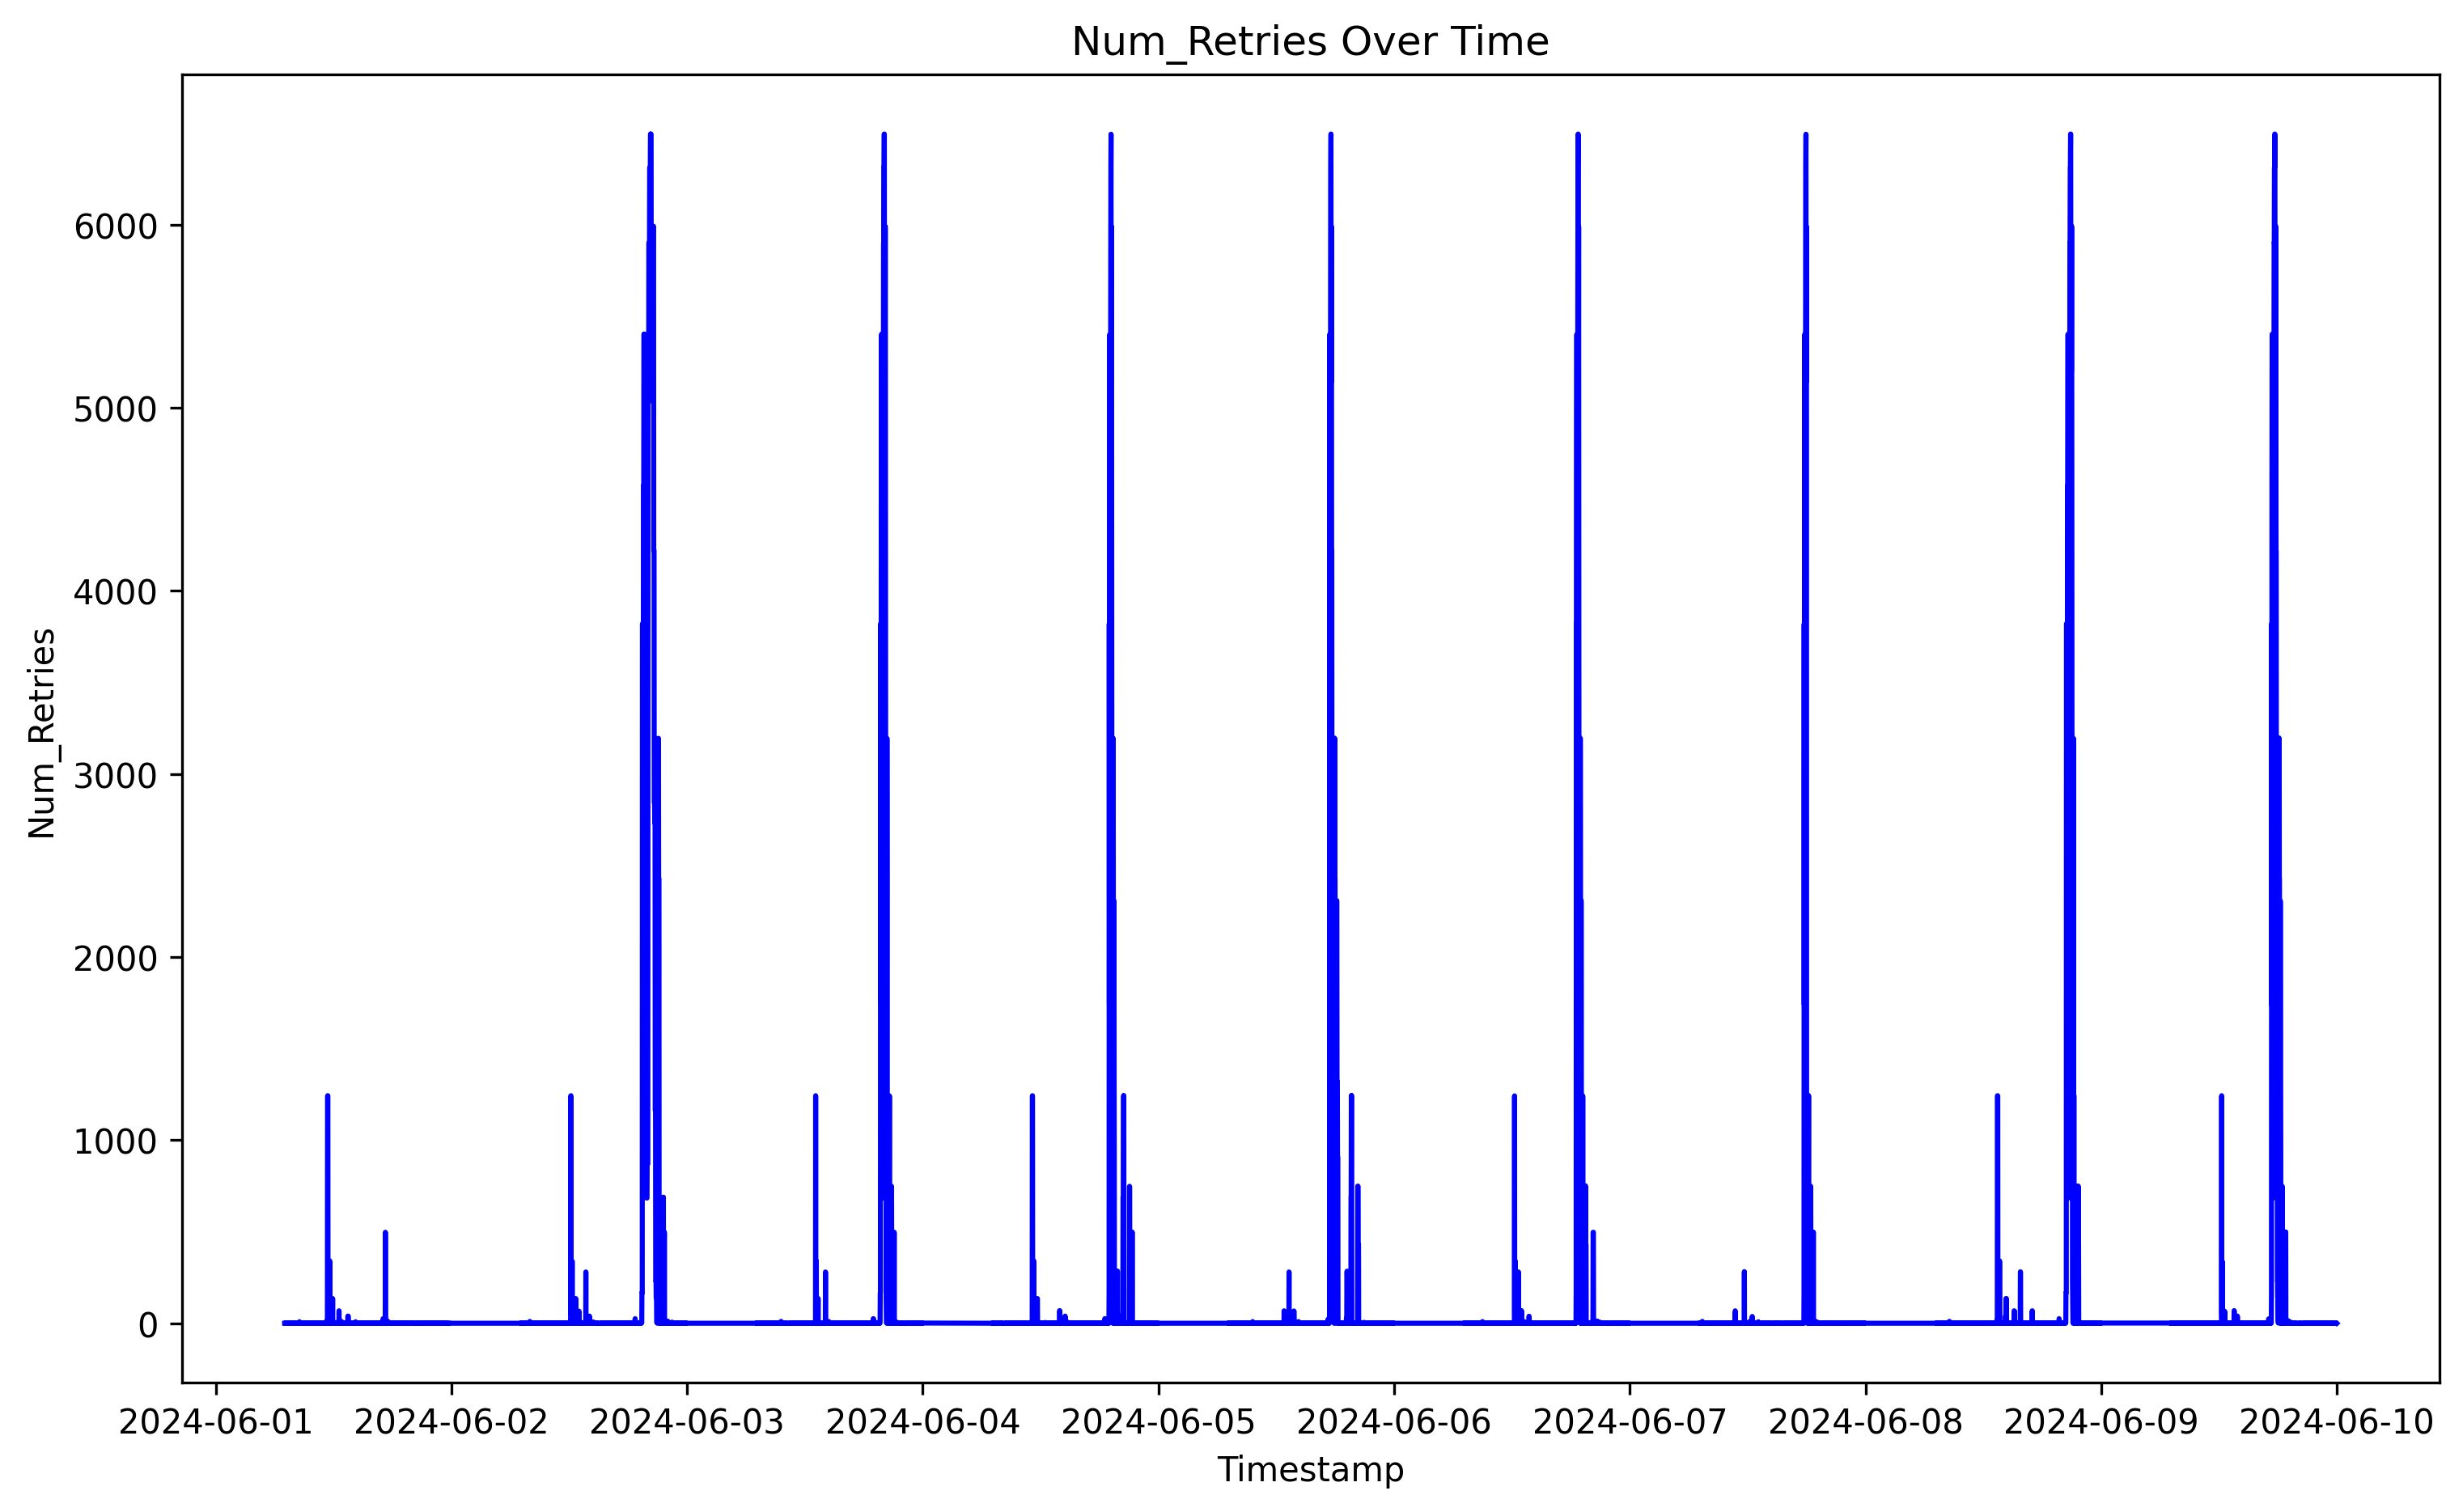

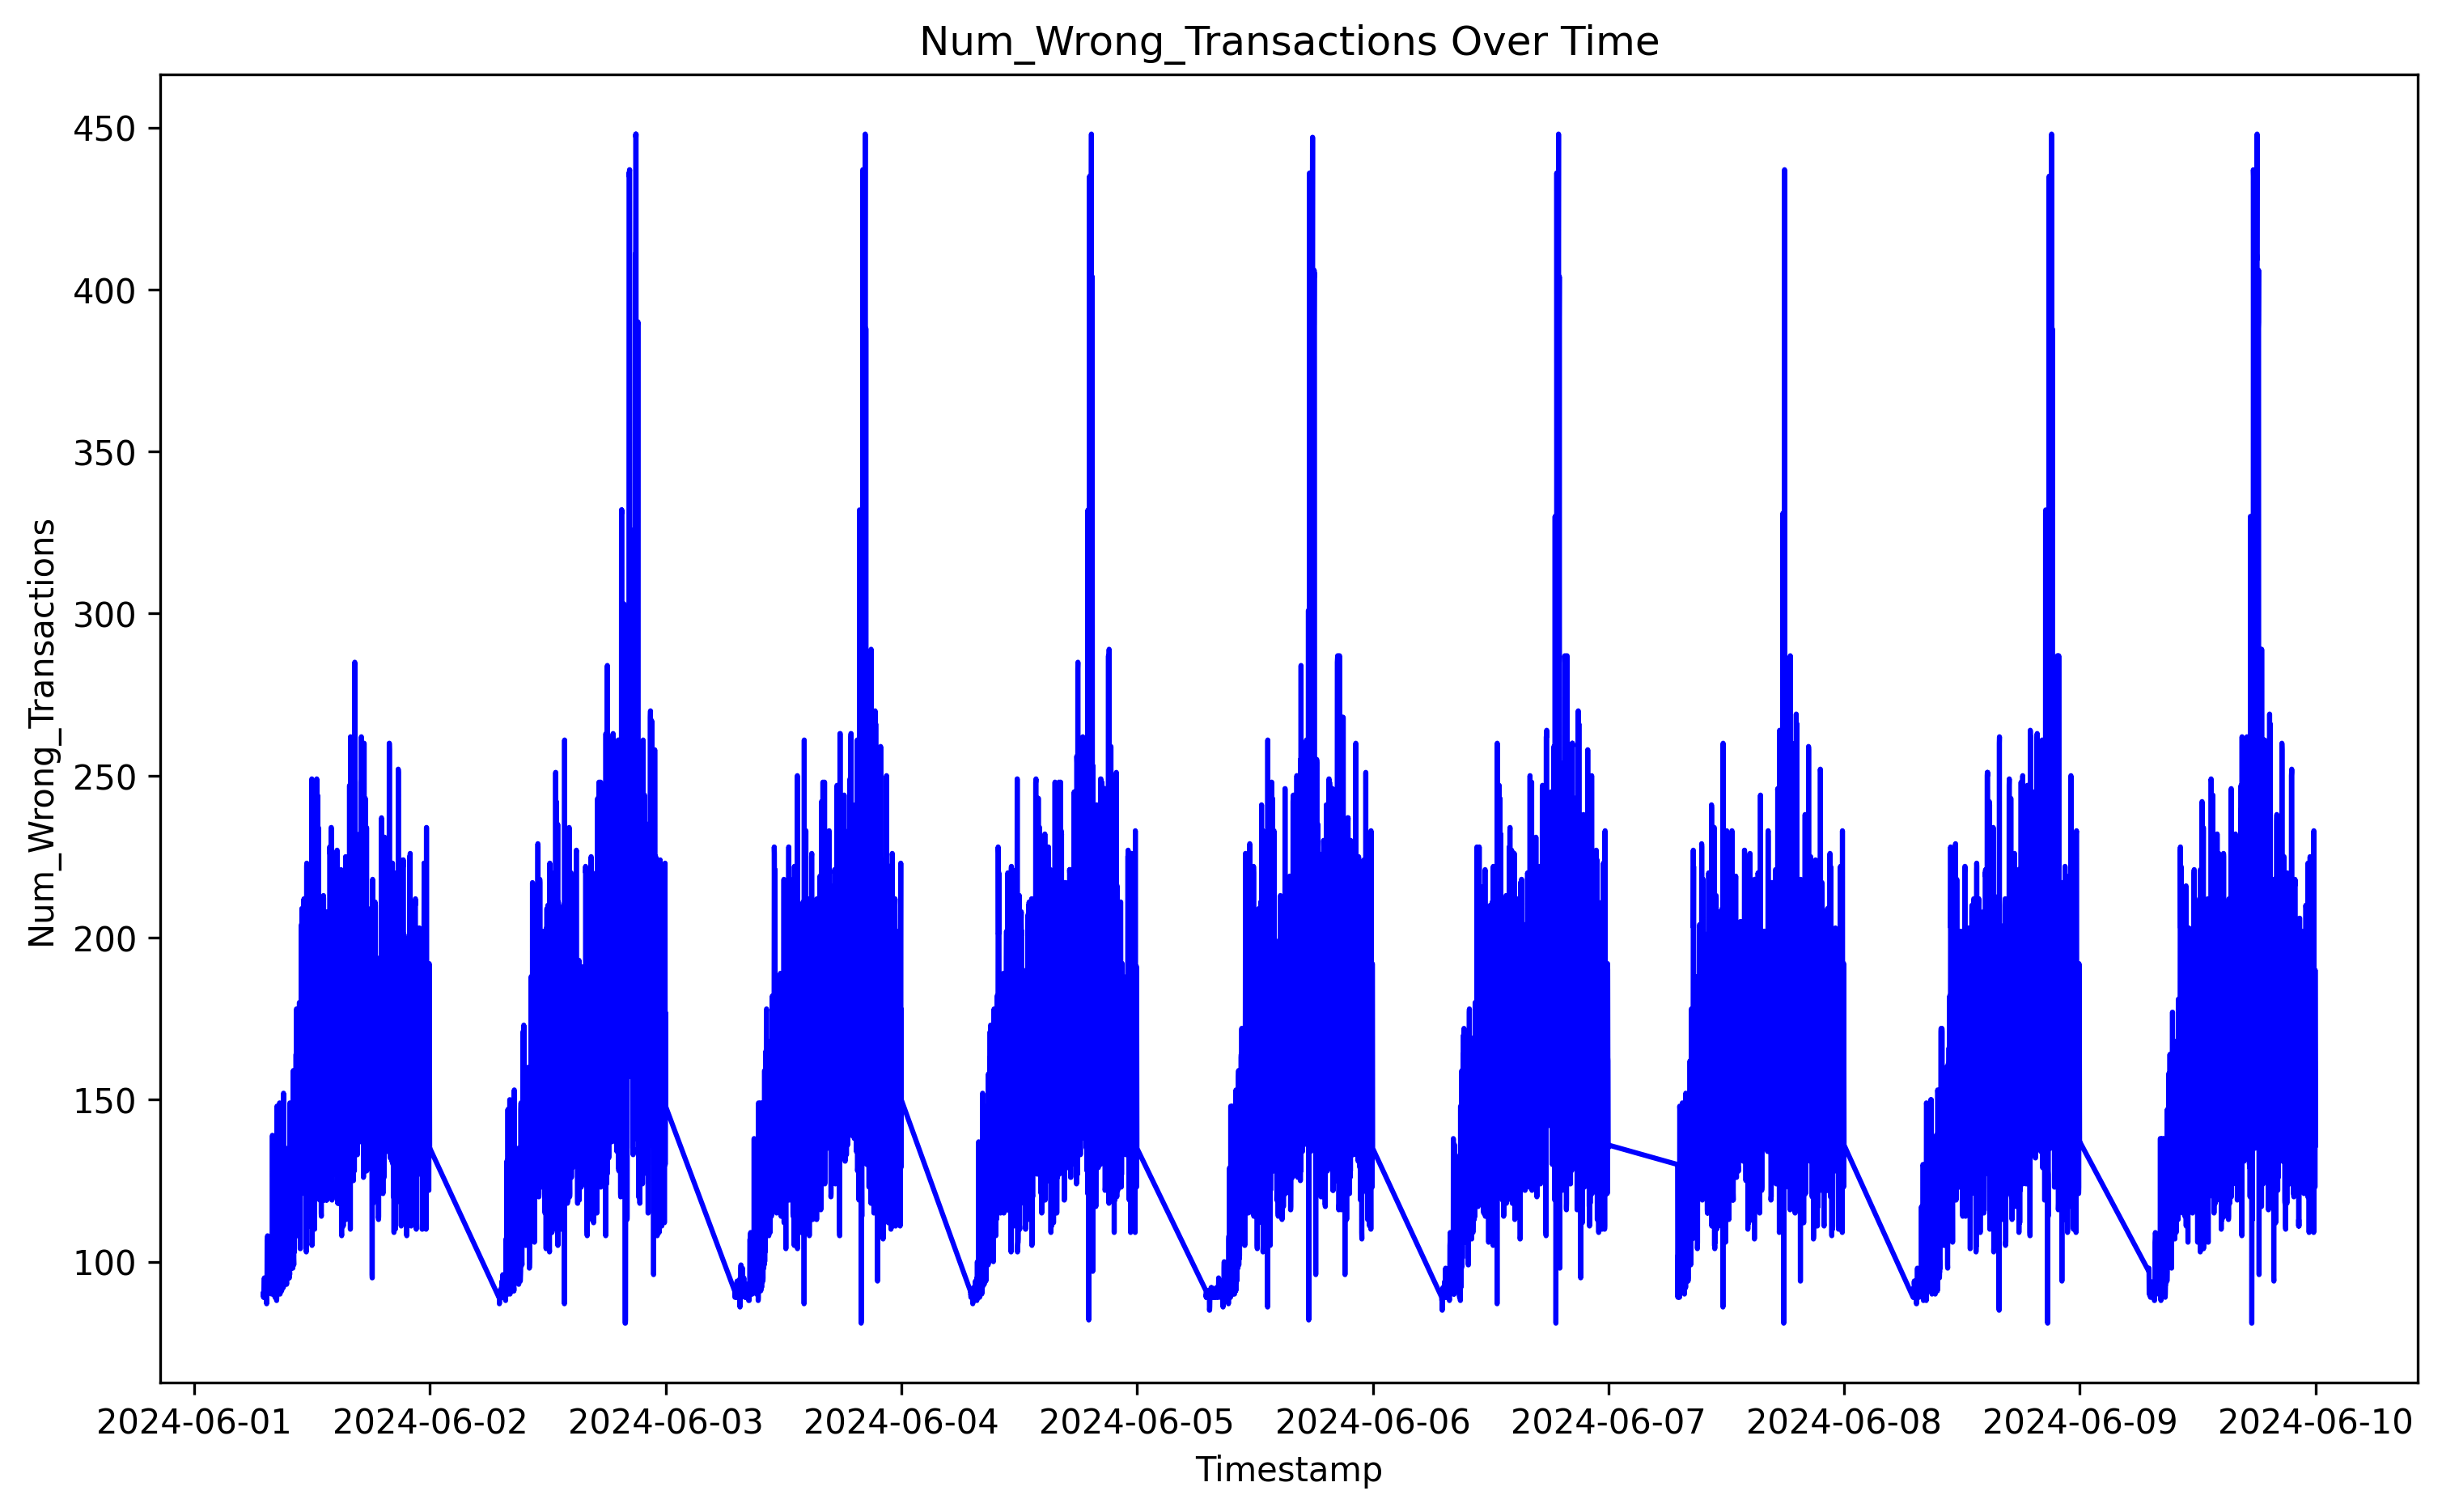

In [11]:
for feat in [
    "Num_Transactions",
    "Time_Max",
    "Time_Min",
    "Mean_Time",
    "Num_Retries",
    "Num_Wrong_Transactions",
]:
    plt.figure()
    plt.plot(gen_data["Timestamp"], gen_data[feat], color="b")
    plt.title(f"{feat} Over Time")
    plt.xlabel("Timestamp")
    plt.ylabel(feat)
    plt.show()

In [19]:
def augment_windows(X, y, n_augment=2, noise_std=0.01, scale_range=(0.9, 1.1)):
    """
    Given X: (N, w, D), y: (N, D), produces n_augment copies of each
    sample by adding Gaussian noise and a random global scale per feature.
    Returns X_aug: (N*n_augment, w, D), y_aug: (N*n_augment, D).
    """
    N, w, D = X.shape
    X_aug_list = []
    y_aug_list = []
    for _ in range(n_augment):
        # 1) Noise
        noise_X = np.random.normal(0, noise_std, size=(N, w, D))
        noise_y = np.random.normal(0, noise_std, size=(N, D))
        Xn = X + noise_X
        yn = y + noise_y
        # 2) random per-feature scale
        scales = np.random.uniform(scale_range[0], scale_range[1], size=(1, 1, D))
        Xs = Xn * scales
        ys = yn * scales.reshape(1, D)
        X_aug_list.append(Xs)
        y_aug_list.append(ys)
    X_aug = np.concatenate(X_aug_list, axis=0)
    y_aug = np.concatenate(y_aug_list, axis=0)
    return X_aug, y_aug


def train_forecaster(
    df,
    features_to_use,
    window_size=30,
    epochs=20,
    batch_size=16,
    augment=False,
    n_augment=2,
    noise_std=0.01,
    scale_range=(0.9, 1.1),
):
    """
    Trains a multi‐feature LSTM forecaster, with optional data augmentation.

    Arguments:
      df          : pd.DataFrame, DateTimeIndex, D numeric cols
      window_size : int, # of past records to use for each prediction
      features_to_use : list of str, names of columns to use
      epochs      : int
      batch_size  : int
      augment     : bool, whether to augment the X,y windows
      n_augment   : int, # of augmented copies per original sample
      noise_std   : float, std dev of additive Gaussian noise
      scale_range : (low,high), uniform scales applied per feature

    Returns:
      predict_future(past_df, steps) → DataFrame of forecasts
      indexed by future timestamps.
    """
    # 1) timestamp handling
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("`df` must have a DateTimeIndex")
    diffs = df.index.to_series().diff().dropna()
    delta = diffs.median()

    # 2) scale all D columns
    values = df[features_to_use].values  # (N, D)
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(values)
    N, D = scaled.shape

    # 3) build one-step (X,y)
    X, y = [], []
    print(f"records_per_day: {records_per_day}")
    print(f"window_size: {window_size}")
    print(f"total records: {N}")
    print(f"total days: {N / records_per_day}")
    print(f"total windows: {N - window_size}")
    for i in range(int(N / records_per_day)):
        base = np.max([int(i * records_per_day) - 1, 0])
        print(f"base: {base}")
        for i in range(records_per_day - window_size):
            start_i = base + i
            X.append(scaled[start_i : start_i + window_size, :])  # (w, D)
            y.append(scaled[start_i + window_size, :])  # (D,)
    X = np.stack(X, axis=0)  # (N - ((N / records_per_day) * w), w, D)
    y = np.stack(y, axis=0)  # (N - ((N / records_per_day) * w), D)

    # 4) optionally augment
    if augment:
        X_aug, y_aug = augment_windows(
            X, y, n_augment=n_augment, noise_std=noise_std, scale_range=scale_range
        )
        X = np.concatenate([X, X_aug], axis=0)
        y = np.concatenate([y, y_aug], axis=0)

    # 5) define & train LSTM
    model = models.Sequential(
        [
            layers.LSTM(128, return_sequences=True, input_shape=(window_size, D)),
            layers.LSTM(64, return_sequences=True),
            layers.LSTM(32, activation="tanh"),
            layers.Dense(64, activation="relu"),
            layers.Dense(D),
        ]
    )
    model.compile(optimizer="adam", loss="mae")
    # Plot the training history
    history = model.fit(
        X, y, epochs=epochs, batch_size=batch_size, verbose=1, validation_split=0.2
    )
    # Create subplots side by side
    plt.figure(figsize=(12, 4))
    plt.plot(history.history["loss"], label="train", color="blue")
    plt.plot(history.history["val_loss"], label="validation", color="orange")
    plt.title("Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend()

    # 6) forecasting
    def predict_future(past_df, steps):
        """
        Predicts n records into the future, given a past_df of
        window_size rows. 
        The predictions are returned as a DataFrame with
        the same columns as the input DataFrame, and the
        index is the future timestamps.

        Arguments:
        past_df  : pd.DataFrame, DateTimeIndex, D numeric cols
        steps    : int, # of records to predict

        Returns:
        DataFrame of forecasts indexed by future timestamps.
        """
        if not isinstance(past_df.index, pd.DatetimeIndex):
            raise ValueError("`past_df` must have a DateTimeIndex")
        if len(past_df) < window_size:
            raise ValueError(f"Need ≥{window_size} rows, got {len(past_df)}")

        arr = past_df[features_to_use].values  # (M, D)
        scaled_arr = scaler.transform(arr)
        window = scaled_arr[-window_size:]  # (w, D)

        preds = []
        for _ in range(steps):
            inp = window.reshape(1, window_size, D)
            nxt = model.predict(inp, verbose=0).reshape(-1)  # (D,)
            preds.append(nxt)
            window = np.concatenate([window[1:], nxt.reshape(1, D)], axis=0)

        # invert & round
        preds = np.stack(preds, axis=0)  # (steps, D)
        inv = scaler.inverse_transform(preds)
        inv = np.rint(inv).astype(int)

        last_ts = past_df.index[-1]
        future_idx = [last_ts + delta * i for i in range(1, steps + 1)]
        return pd.DataFrame(inv, index=future_idx, columns=features_to_use)

    return predict_future


records_per_day: 1018
window_size: 30
total records: 9162
total days: 9.0
total windows: 9132
base: 0
base: 1017
base: 2035
base: 3053
base: 4071
base: 5089
base: 6107
base: 7125
base: 8143


/home/ghms28/.cache/pypoetry/virtualenvs/codeine-anomaly-detection-qcAgHhgl-py3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/80
1334/1334 ━━━━━━━━━━━━━━━━━━━━ 105s 74ms/step - loss: 0.0517 - val_loss: 0.0449
Epoch 2/80
1334/1334 ━━━━━━━━━━━━━━━━━━━━ 112s 84ms/step - loss: 0.0428 - val_loss: 0.0430
Epoch 3/80
1334/1334 ━━━━━━━━━━━━━━━━━━━━ 112s 84ms/step - loss: 0.0424 - val_loss: 0.0416
Epoch 4/80
1334/1334 ━━━━━━━━━━━━━━━━━━━━ 106s 80ms/step - loss: 0.0402 - val_loss: 0.0409
Epoch 5/80
1334/1334 ━━━━━━━━━━━━━━━━━━━━ 105s 79ms/step - loss: 0.0398 - val_loss: 0.0408
Epoch 6/80
1334/1334 ━━━━━━━━━━━━━━━━━━━━ 104s 78ms/step - loss: 0.0393 - val_loss: 0.0410
Epoch 7/80
1334/1334 ━━━━━━━━━━━━━━━━━━━━ 109s 82ms/step - loss: 0.0389 - val_loss: 0.0399
Epoch 8/80
1334/1334 ━━━━━━━━━━━━━━━━━━━━ 110s 83ms/step - loss: 0.0387 - val_loss: 0.0393
Epoch 9/80
1334/1334 ━━━━━━━━━━━━━━━━━━━━ 110s 82ms/step - loss: 0.0382 - val_loss: 0.0390
Epoch 10/80
1334/1334 ━━━━━━━━━━━━━━━━━━━━ 111s 83ms/step - loss: 0.0376 - val_loss: 0.0387
Epoch 11/80
1334/1334 ━━━━━━━━━━━━━━━━━━━━ 110s 82ms/step - loss: 0.0367 - val_loss: 0.03

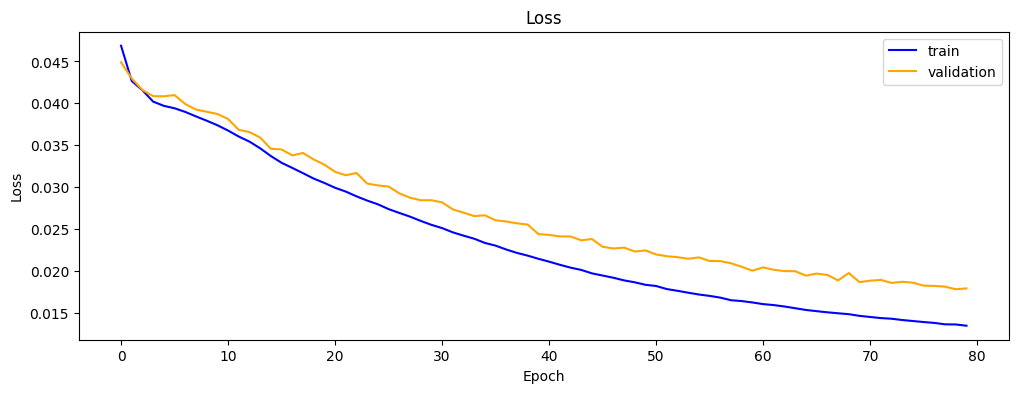

In [ ]:
window_size = 30
epochs = 80

features_to_use = [
    "Num_Transactions",
    "Time_Min",
    "Time_Max",
    "Mean_Time",
    "Num_Retries",
    "Num_Wrong_Transactions",
]

df = pd.concat([raw_df, 
                gen_data.iloc[: 8 * 1018]
                ]).set_index("Timestamp")


forecastfn = train_forecaster(
    df,
    features_to_use,
    window_size,
    augment=True,
    epochs=epochs,
    batch_size=16,
)


In [ ]:
pd.concat(
    [raw_df, gen_data.iloc[: 8 * 1018]]
).set_index("Timestamp")

,Code_ID,Interval_s,Num_Transactions,Time_Min,Time_Max,Mean_Time,Num_Retries,Num_Wrong_Transactions
Timestamp,,,,,,,,
2024-05-31 07:01:11,8,60,366,6,1019,25.907562,0,90
2024-05-31 07:02:11,8,60,948,7,90,18.181719,0,90
2024-05-31 07:03:11,8,60,1273,7,408,18.813356,0,90
2024-05-31 07:04:11,8,60,1538,6,70,16.607435,0,90
2024-05-31 07:05:11,8,60,703,5,85,16.645409,0,90
...,...,...,...,...,...,...,...,...
2024-08-06 23:55:23,8,60,1083,2,28,15.110000,1,202
2024-08-06 23:56:23,8,60,1241,2,28,15.495000,1,140
2024-08-06 23:57:23,8,60,1239,3,615,309.045000,0,140


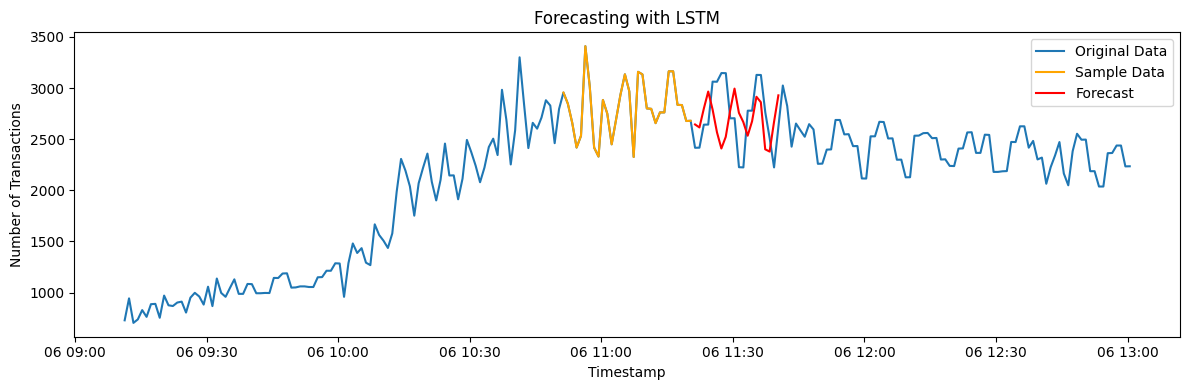

In [ ]:
predict_size = 20

start_point = 230
end_point = start_point + window_size
test_data = gen_data.iloc[8 * 1018:].set_index("Timestamp")
sample_date = test_data[start_point:end_point]
forecast = forecastfn(sample_date, predict_size)


plot_padding = 100
subtest_data = test_data[start_point - plot_padding : end_point + plot_padding]

plt.figure(figsize=(12, 4))
plt.plot(subtest_data.index, subtest_data['Num_Transactions'], label='Original Data')
plt.plot(sample_date.index, sample_date['Num_Transactions'], label='Sample Data', color='orange')
plt.plot(forecast.index, forecast['Num_Transactions'], label='Forecast', color='red')
plt.xlabel('Timestamp')
plt.ylabel('Number of Transactions')
plt.title('Forecasting with LSTM')
plt.legend()
plt.tight_layout()
plt.show()


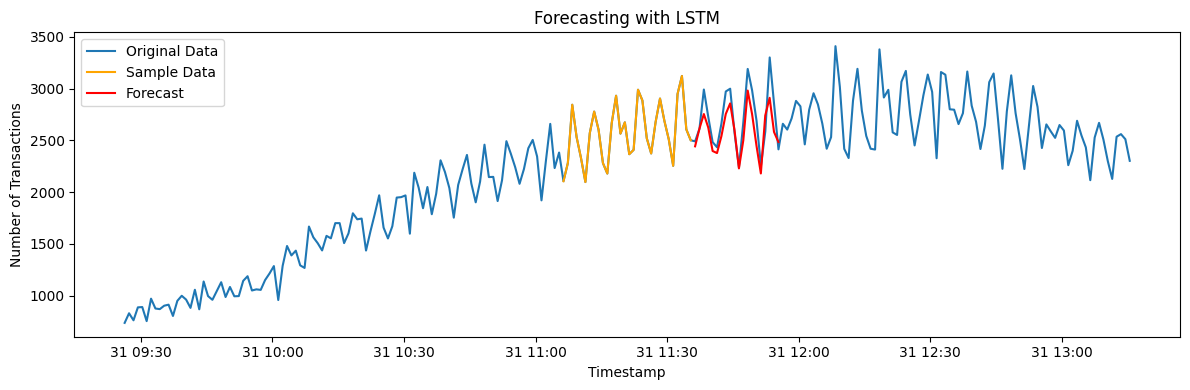

In [25]:
predict_size = 20

start_point = 245
end_point = start_point + window_size

sample_date = df[start_point:end_point]
forecast = forecastfn(sample_date, predict_size)


plot_padding = 100
subdf = df[start_point - plot_padding : end_point + plot_padding]

plt.figure(figsize=(12, 4))
plt.plot(subdf.index, subdf['Num_Transactions'], label='Original Data')
plt.plot(sample_date.index, sample_date['Num_Transactions'], label='Sample Data', color='orange')
plt.plot(forecast.index, forecast['Num_Transactions'], label='Forecast', color='red')
plt.xlabel('Timestamp')
plt.ylabel('Number of Transactions')
plt.title('Forecasting with LSTM')
plt.legend()
plt.tight_layout()
plt.show()


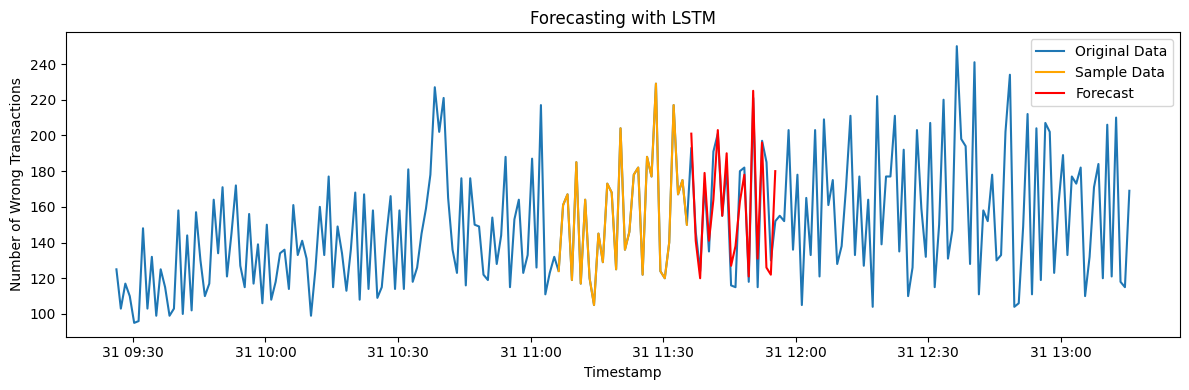

In [26]:
plt.figure(figsize=(12, 4))
plt.plot(subdf.index, subdf['Num_Wrong_Transactions'], label='Original Data')
plt.plot(sample_date.index, sample_date['Num_Wrong_Transactions'], label='Sample Data', color='orange')
plt.plot(forecast.index, forecast['Num_Wrong_Transactions'], label='Forecast', color='red')
plt.xlabel('Timestamp')
plt.ylabel('Number of Wrong Transactions')
plt.title('Forecasting with LSTM')
plt.legend()
plt.tight_layout()
plt.show()

In [27]:
def augment_points(X, n_augment=2, noise_std=0.01, scale_range=(0.9, 1.1)):
    """
    X: (N, D) array of normalized features.
    Returns n_augment noisy+scaled copies of X, shape (N*n_augment, D).
    """
    N, D = X.shape
    aug_list = []
    for _ in range(n_augment):
        noise = np.random.normal(0, noise_std, size=(N, D))
        Xn = X + noise
        scales = np.random.uniform(scale_range[0], scale_range[1], size=(1, D))
        aug_list.append(Xn * scales)
    return np.vstack(aug_list)


def train_anomaly_detector(
    df,
    features_to_use,
    augment=False,
    n_augment=2,
    noise_std=0.01,
    scale_range=(0.9, 1.1),
    latent_dim=16,
    epochs=20,
    batch_size=32,
):
    """
    Train a point-wise autoencoder on df (must be DateTimeIndex, numeric cols).
    Optionally augment your data. Returns a detect() function.

    detect(pred_df) → DataFrame w/ columns:
      • all original features,
      • recon_error  (MSE per row),
      • is_anomaly   (bool: error > threshold).
    """
    # 1) check and extract
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("`df` must have a DateTimeIndex")
    X_raw = df[features_to_use].values.astype(float)  # shape (N, D)
    N, D = X_raw.shape

    # 2) normalize to [0,1]
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X_raw)

    # 3) augment if requested
    if augment:
        X_aug = augment_points(
            X, n_augment=n_augment, noise_std=noise_std, scale_range=scale_range
        )
        X_train = np.vstack([X, X_aug])
    else:
        X_train = X

    # 4) build a simple feed-forward autoencoder
    ae = Sequential(
        [
            layers.Dense(64, activation="relu", input_shape=(D,)),
            layers.Dense(latent_dim, activation="relu"),
            layers.Dense(64, activation="relu"),
            layers.Dense(D, activation="sigmoid"),
        ]
    )
    ae.compile(optimizer="adam", loss="mse")
    ae.fit(X_train, X_train, epochs=epochs, batch_size=batch_size, verbose=1)

    # 5) set anomaly threshold
    recon = ae.predict(X, verbose=0)
    # per-sample MSE:  MSE_i = (1/D) ∑_j (x_ij - xhat_ij)^2
    mse = np.mean((recon - X) ** 2, axis=1)

    # 6) return detection closure
    def detect(pred_df, threshold_quantile=0.99):
        """
        pred_df: same columns as df, DateTimeIndex, shape (M, D)
        Returns new DataFrame with added columns:
          - recon_error : float
          - is_anomaly  : bool
        """
        thresh = np.quantile(mse, threshold_quantile)
        if not isinstance(pred_df.index, pd.DatetimeIndex):
            raise ValueError("`pred_df` must have a DateTimeIndex")

        Xp_raw = pred_df[features_to_use].values.astype(float)
        Xp = scaler.transform(Xp_raw)
        Xp_hat = ae.predict(Xp, verbose=0)
        err = np.mean((Xp_hat - Xp) ** 2, axis=1)
        out = pred_df.copy()
        out["recon_error"] = err
        out["is_anomaly"] = err > thresh
        return out

    return detect


In [28]:
# 1. Train on your history
detect = train_anomaly_detector(
    df,
    features_to_use=features_to_use,
    augment=True,
    n_augment=10,
    noise_std=0.02,
    scale_range=(0.9, 1.1),
    latent_dim=16,
    epochs=300,
    batch_size=64,
)

/home/ghms28/.cache/pypoetry/virtualenvs/codeine-anomaly-detection-qcAgHhgl-py3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/300
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0207
Epoch 2/300
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 3.3697e-04
Epoch 3/300
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 2.7586e-04
Epoch 4/300
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 2.3541e-04
Epoch 5/300
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 2.0116e-04
Epoch 6/300
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 1.8181e-04
Epoch 7/300
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.7018e-04
Epoch 8/300
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.5711e-04
Epoch 9/300
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.4160e-04
Epoch 10/300
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.2624e-04
Epoch 11/300
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.1822e-04
Epoch 12/300
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.1453e-04
Epoch 13/300
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.1062e-04
Epoch 14/300
1575/1575 ━━━━━━━━━━━━━━━

In [29]:
# 2. Suppose `forecast_df` is the DataFrame your LSTM forecaster produced:
anomalies = detect(df, threshold_quantile=0.98)
print(anomalies[anomalies.is_anomaly])


                     Code_ID  Interval_s  Num_Transactions  Time_Min  \
Timestamp                                                              
2024-05-31 07:02:11        8          60               948         7   
2024-05-31 07:03:11        8          60              1273         7   
2024-05-31 18:18:47        8          60              4901         3   
2024-05-31 18:34:48        8          60              2725         0   
2024-05-31 18:35:49        8          60              3945         0   
...                      ...         ...               ...       ...   
2024-08-06 16:56:43        8          60              2994         0   
2024-08-06 17:05:43        8          60              3239         0   
2024-08-06 17:06:43        8          60              3241         0   
2024-08-06 17:07:43        8          60              3281         0   
2024-08-06 17:08:44        8          60              3282         0   

                     Time_Max     Mean_Time  Num_Retries  \
Tim

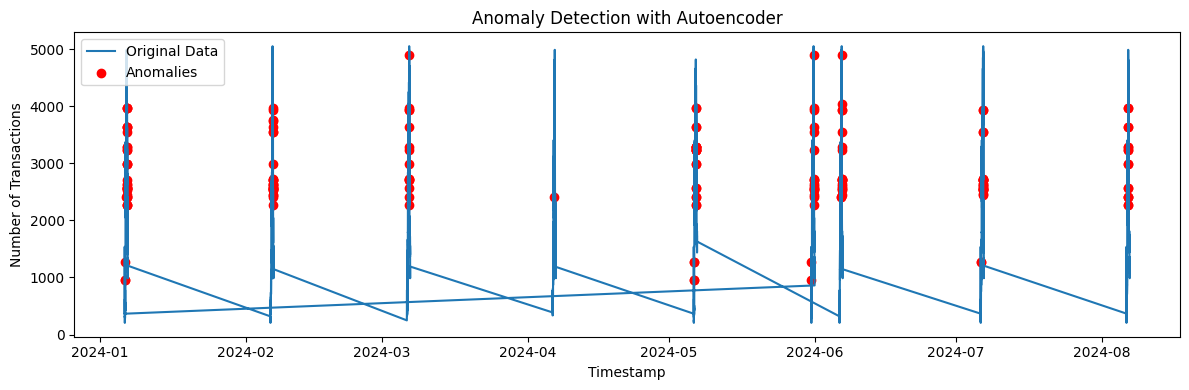

In [30]:
# show anomalies with dots
plt.figure(figsize=(12, 4))
plt.plot(df.index, df['Num_Transactions'], label='Original Data')
plt.scatter(anomalies.index[anomalies.is_anomaly],
            df['Num_Transactions'][anomalies.is_anomaly],
            color='red', label='Anomalies')
plt.xlabel('Timestamp')
plt.ylabel('Number of Transactions')
plt.title('Anomaly Detection with Autoencoder')
plt.legend()
plt.tight_layout()
plt.show()

                     Num_Transactions  Time_Min  Time_Max  Mean_Time  \
2024-05-31 18:36:47              2437         0     27467      -1022   
2024-05-31 18:37:47              3378         0     33745        -77   
2024-05-31 18:42:47              2590         0     28002       1298   
2024-05-31 18:43:47              2345         0     44105       1900   
2024-05-31 18:45:47              2503         0     69655       2477   
2024-05-31 18:46:47              2307         0     74879       1688   
2024-05-31 18:47:47              2337         0     82639       1527   
2024-05-31 18:49:47              2407         0     89466       1392   
2024-05-31 18:51:47              2286         0     38156       1699   
2024-05-31 18:55:47              3342         1      2169        843   

                     Num_Retries  Num_Wrong_Transactions  recon_error  \
2024-05-31 18:36:47         4068                     149     0.000156   
2024-05-31 18:37:47         5244                     199     

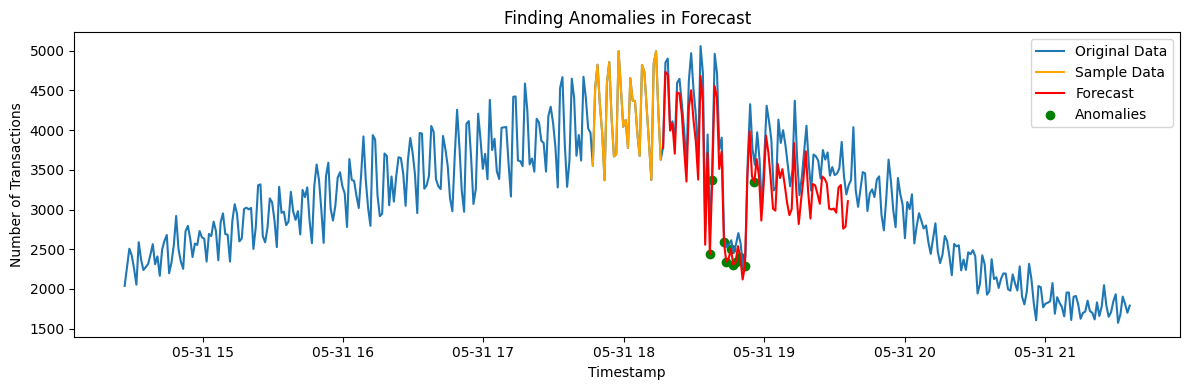

In [31]:
predict_size = 80

start_point = 645
end_point = start_point + window_size

sample_date = df[start_point:end_point][features_to_use]
forecast = forecastfn(sample_date, predict_size)

anomalies = detect(forecast,threshold_quantile=0.99)
print(anomalies[anomalies.is_anomaly])

plot_padding = 200
# ! Rename, should not be the same as the one above
subdf = df[start_point - plot_padding : end_point + plot_padding]




plt.figure(figsize=(12, 4))
plt.plot(subdf.index, subdf['Num_Transactions'], label='Original Data')
plt.plot(sample_date.index, sample_date['Num_Transactions'], label='Sample Data', color='orange')
plt.plot(forecast.index, forecast['Num_Transactions'], label='Forecast', color='red')
plt.scatter(anomalies.index[anomalies.is_anomaly],
            forecast['Num_Transactions'][anomalies.is_anomaly],
            color='green', label='Anomalies')
plt.xlabel('Timestamp')
plt.ylabel('Number of Transactions')
plt.title('Finding Anomalies in Forecast')
plt.legend()
plt.tight_layout()
plt.show()


Empty DataFrame
Columns: [Num_Transactions, Time_Min, Time_Max, Mean_Time, Num_Retries, Num_Wrong_Transactions, recon_error, is_anomaly]
Index: []


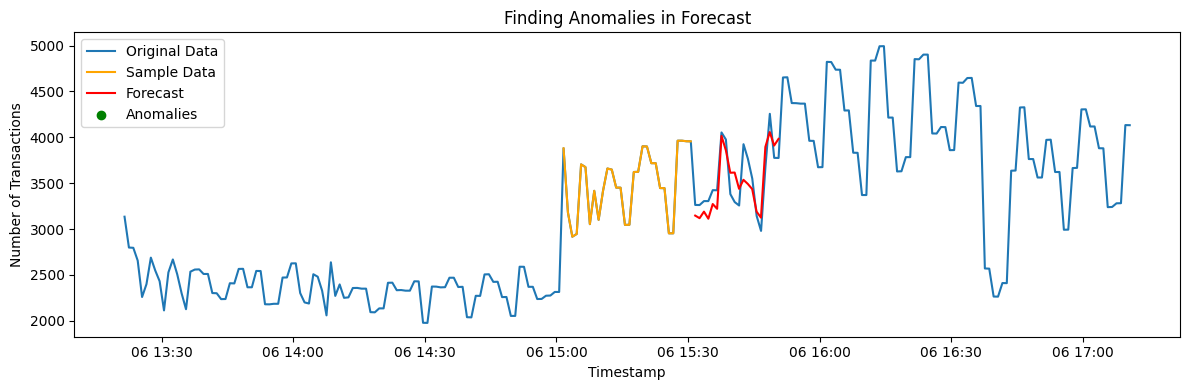

In [ ]:
predict_size = 20

start_point = 480
end_point = start_point + window_size

test_data = gen_data.iloc[7 * 1018:].set_index("Timestamp")[features_to_use]
sample_date = test_data[start_point:end_point]

# sample_date = df[start_point:end_point]
forecast = forecastfn(sample_date, predict_size)

anomalies = detect(forecast,threshold_quantile=0.99)
print(anomalies[anomalies.is_anomaly])

plot_padding = 100
# ! Rename, should not be the same as the one above
subdf = test_data[start_point - plot_padding : end_point + plot_padding]




plt.figure(figsize=(12, 4))
plt.plot(subdf.index, subdf['Num_Transactions'], label='Original Data')
plt.plot(sample_date.index, sample_date['Num_Transactions'], label='Sample Data', color='orange')
plt.plot(forecast.index, forecast['Num_Transactions'], label='Forecast', color='red')
plt.scatter(anomalies.index[anomalies.is_anomaly],
            forecast['Num_Transactions'][anomalies.is_anomaly],
            color='green', label='Anomalies')
plt.xlabel('Timestamp')
plt.ylabel('Number of Transactions')
plt.title('Finding Anomalies in Forecast')
plt.legend()
plt.tight_layout()
plt.show()
